Name- Vidhi Mittal, Vanisha Agrawal

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Importing Data

In [113]:
!pip install -q kaggle

In [114]:
from google.colab import files
uploaded=files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

In [ ]:
!unzip aptos2019-blindness-detection

## Visualizing the Dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from matplotlib import pyplot as plt
import cv2 # for image pre-processing
import gc
from tqdm import tqdm
import glob

In [ ]:
# Defining a global variable to be used as Image size..
IMG_SIZE = 224

In [ ]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
    train = pd.read_csv('/content/train.csv')
    test = pd.read_csv('/content/test.csv')
    
    train_dir = os.path.join('/content/train_images')
    test_dir = os.path.join('/content/test_images')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [ ]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



id_code diagnosis                               file_path  \
0  000c1434d8d7         2  /content/train_images/000c1434d8d7.png   
1  001639a390f0         4  /content/train_images/001639a390f0.png   
2  0024cdab0c1e         1  /content/train_images/0024cdab0c1e.png   
3  002c21358ce6         0  /content/train_images/002c21358ce6.png   
4  005b95c28852         0  /content/train_images/005b95c28852.png   
5  0083ee8054ee         4  /content/train_images/0083ee8054ee.png   

          file_name  
0  000c1434d8d7.png  
1  001639a390f0.png  
2  0024cdab0c1e.png  
3  002c21358ce6.png  
4  005b95c28852.png  
5  0083ee8054ee.png

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show() 

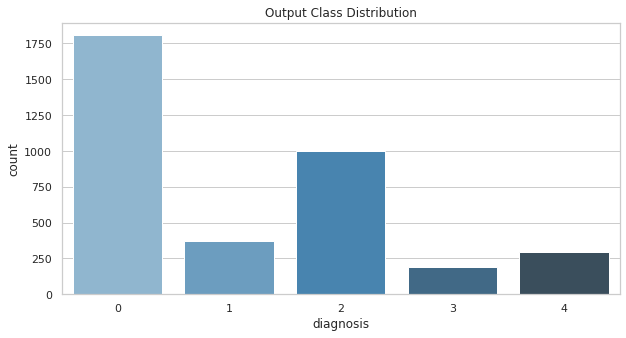

In [ ]:
plot_classes(df_train)

## Data Prepocessing

In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))
        plt.show()

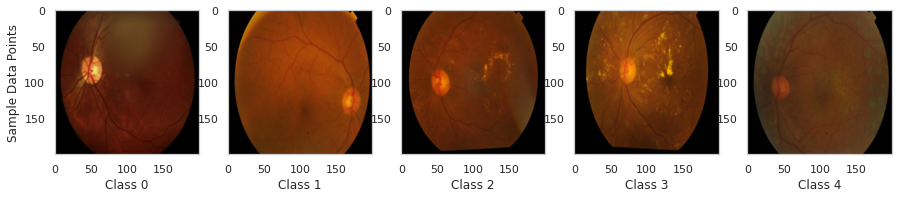

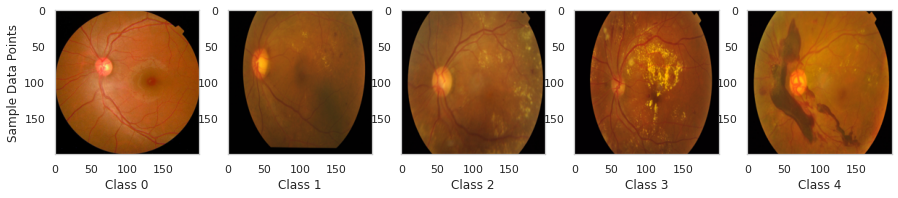

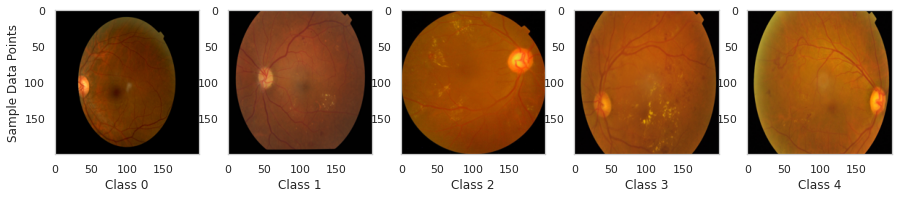

In [ ]:
visualize_imgs(df_train,3,color_scale = None)

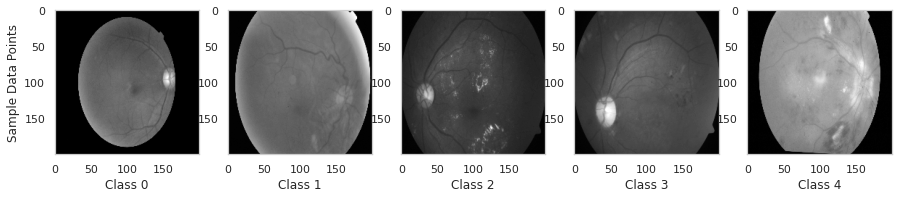

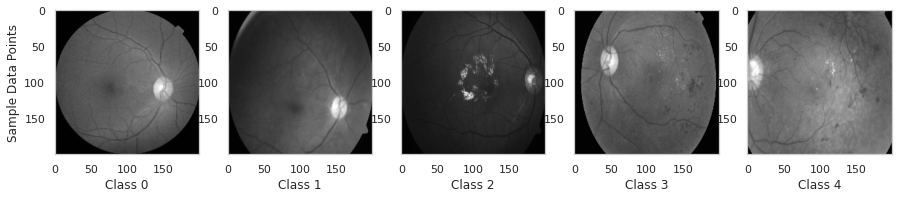

In [ ]:
visualize_imgs(df_train,2,color_scale = 'gray')

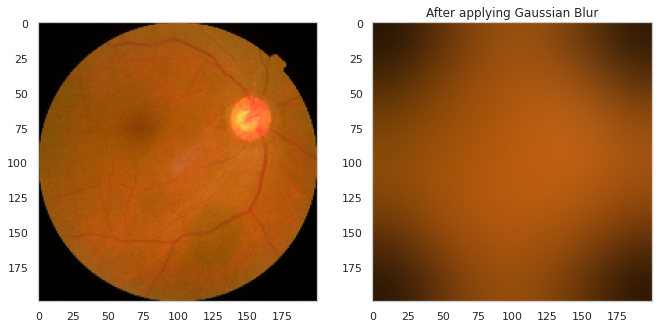

In [ ]:
'''
This section of code applies gaussian blur on top of image
'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.GaussianBlur(img , (0,0) , 30) 

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

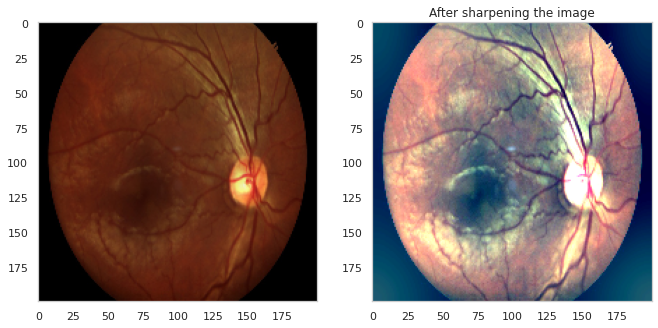

In [ ]:
'''
This section of code uses the mask made for gaussian blur to sharpen the image so that the shapr lines of viens, haemmorhages and exudates 
'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After sharpening the image')
plt.show()

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    """
    Create circular crop around image centre    
    """ 
       
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img) 
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.resize(img, (224, 224))
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
   
    return img 

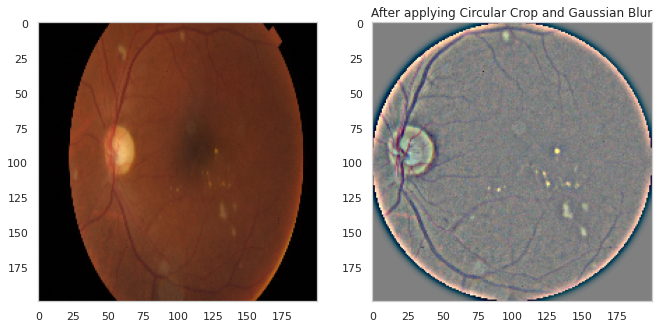

In [ ]:
'''Perform Image Processing on a sample image'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

#img = img_t
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

In [ ]:
'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class) 
and performs image processing (Gaussian Blur, Circular crop) transformation on top of that
'''

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

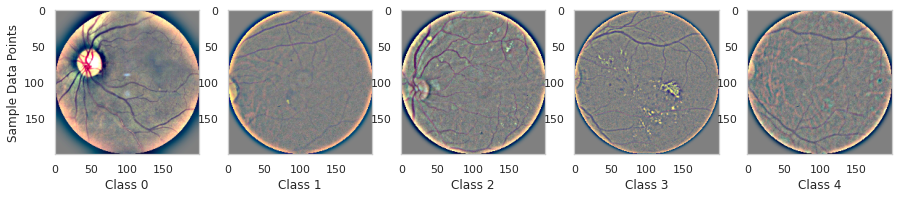

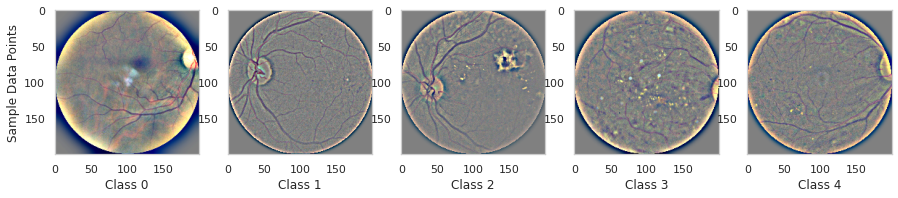

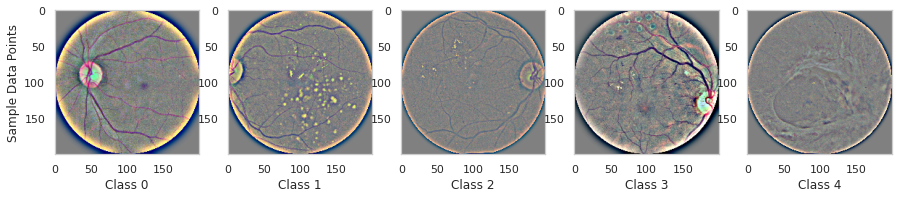

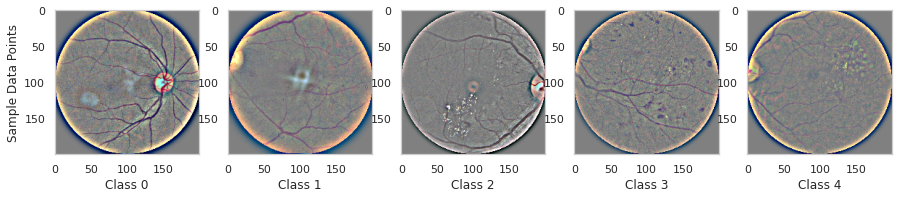

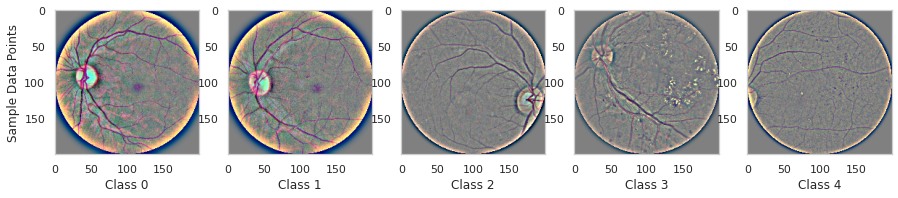

In [ ]:
visualize_img_process(df_train,5,sigmaX = 30)

In [ ]:
from tqdm import tqdm

X_train=[]
Y_train=[]

for i in tqdm(range(0,len(df_train))):
  # img=cv2.imread(path)
  img = cv2.imread(df_train.file_path.iloc[i])
  # img=cv2.resize(img, (300, 300))

  img = circle_crop(img,sigmaX=10)
  X_train.append(img)
  temp=[]
  print(df_train.diagnosis.iloc[i])
  for j in range(0,5):
     if(j==int(df_train.diagnosis.iloc[i])):
      temp.append(1)
     else:
      temp.append(0)
  print(temp)
  Y_train.append(temp)

  0%|          | 1/3662 [00:00<22:50,  2.67it/s]

2
[0, 0, 1, 0, 0]


  0%|          | 3/3662 [00:00<15:15,  4.00it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


  0%|          | 5/3662 [00:00<09:35,  6.36it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  0%|          | 6/3662 [00:01<14:08,  4.31it/s]

4
[0, 0, 0, 0, 1]


  0%|          | 7/3662 [00:01<14:23,  4.23it/s]

0
[1, 0, 0, 0, 0]


  0%|          | 8/3662 [00:01<15:05,  4.04it/s]

2
[0, 0, 1, 0, 0]


  0%|          | 10/3662 [00:02<13:29,  4.51it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


  0%|          | 12/3662 [00:02<10:45,  5.65it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


  0%|          | 14/3662 [00:02<09:27,  6.42it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


  0%|          | 15/3662 [00:03<11:13,  5.42it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  1%|          | 19/3662 [00:03<09:10,  6.61it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  1%|          | 21/3662 [00:03<07:45,  7.83it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  1%|          | 23/3662 [00:04<07:33,  8.03it/s]

1
[0, 1, 0, 0, 0]


  1%|          | 24/3662 [00:04<11:21,  5.34it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  1%|          | 26/3662 [00:04<09:34,  6.33it/s]

2
[0, 0, 1, 0, 0]


  1%|          | 29/3662 [00:05<08:39,  7.00it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  1%|          | 30/3662 [00:05<09:46,  6.19it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  1%|          | 32/3662 [00:05<09:34,  6.32it/s]

0
[1, 0, 0, 0, 0]


  1%|          | 35/3662 [00:06<08:21,  7.24it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


  1%|          | 38/3662 [00:06<08:08,  7.42it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  1%|          | 39/3662 [00:06<09:22,  6.44it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


  1%|          | 41/3662 [00:07<09:22,  6.43it/s]

4
[0, 0, 0, 0, 1]


  1%|          | 42/3662 [00:07<10:09,  5.94it/s]

2
[0, 0, 1, 0, 0]


  1%|          | 43/3662 [00:07<11:04,  5.45it/s]

2
[0, 0, 1, 0, 0]


  1%|          | 44/3662 [00:07<13:29,  4.47it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


  1%|▏         | 46/3662 [00:08<14:40,  4.11it/s]

1
[0, 1, 0, 0, 0]


  1%|▏         | 47/3662 [00:08<14:50,  4.06it/s]

2
[0, 0, 1, 0, 0]


  1%|▏         | 48/3662 [00:08<15:11,  3.96it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


  1%|▏         | 50/3662 [00:09<12:07,  4.97it/s]

3
[0, 0, 0, 1, 0]


  1%|▏         | 51/3662 [00:09<12:46,  4.71it/s]

1
[0, 1, 0, 0, 0]


  1%|▏         | 52/3662 [00:09<15:41,  3.83it/s]

2
[0, 0, 1, 0, 0]


  1%|▏         | 53/3662 [00:10<15:34,  3.86it/s]

2
[0, 0, 1, 0, 0]


  1%|▏         | 54/3662 [00:10<14:57,  4.02it/s]

2
[0, 0, 1, 0, 0]


  2%|▏         | 55/3662 [00:10<15:13,  3.95it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 57/3662 [00:10<11:42,  5.13it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 60/3662 [00:11<10:21,  5.80it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 62/3662 [00:11<09:43,  6.17it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 65/3662 [00:11<08:20,  7.19it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 67/3662 [00:12<08:30,  7.04it/s]

2
[0, 0, 1, 0, 0]


  2%|▏         | 70/3662 [00:12<07:28,  8.01it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 72/3662 [00:12<09:18,  6.42it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


  2%|▏         | 73/3662 [00:13<09:46,  6.12it/s]

1
[0, 1, 0, 0, 0]


  2%|▏         | 75/3662 [00:13<11:11,  5.34it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


  2%|▏         | 78/3662 [00:13<06:24,  9.31it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 80/3662 [00:14<08:45,  6.82it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 82/3662 [00:14<09:38,  6.19it/s]

1
[0, 1, 0, 0, 0]
3
[0, 0, 0, 1, 0]


  2%|▏         | 83/3662 [00:14<13:53,  4.29it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 86/3662 [00:15<10:53,  5.47it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  2%|▏         | 88/3662 [00:15<10:10,  5.86it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


  2%|▏         | 89/3662 [00:15<09:04,  6.56it/s]

4
[0, 0, 0, 0, 1]


  2%|▏         | 91/3662 [00:16<10:26,  5.70it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


  3%|▎         | 93/3662 [00:16<08:06,  7.34it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  3%|▎         | 95/3662 [00:16<06:21,  9.35it/s]

0
[1, 0, 0, 0, 0]


  3%|▎         | 97/3662 [00:16<07:57,  7.46it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  3%|▎         | 98/3662 [00:17<09:26,  6.29it/s]

3
[0, 0, 0, 1, 0]


  3%|▎         | 99/3662 [00:17<10:38,  5.58it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  3%|▎         | 101/3662 [00:17<10:22,  5.72it/s]

2
[0, 0, 1, 0, 0]


  3%|▎         | 103/3662 [00:18<10:36,  5.59it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  3%|▎         | 104/3662 [00:18<12:04,  4.91it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  3%|▎         | 107/3662 [00:18<11:15,  5.26it/s]

4
[0, 0, 0, 0, 1]
4
[0, 0, 0, 0, 1]


  3%|▎         | 110/3662 [00:19<07:28,  7.91it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


  3%|▎         | 111/3662 [00:19<10:38,  5.56it/s]

2
[0, 0, 1, 0, 0]


  3%|▎         | 112/3662 [00:19<11:54,  4.97it/s]

4
[0, 0, 0, 0, 1]


  3%|▎         | 113/3662 [00:20<12:37,  4.68it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  3%|▎         | 115/3662 [00:20<11:06,  5.32it/s]

2
[0, 0, 1, 0, 0]


  3%|▎         | 118/3662 [00:20<08:42,  6.78it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  3%|▎         | 120/3662 [00:20<07:29,  7.88it/s]

0
[1, 0, 0, 0, 0]


  3%|▎         | 122/3662 [00:21<11:04,  5.33it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


  3%|▎         | 123/3662 [00:21<10:58,  5.37it/s]

2
[0, 0, 1, 0, 0]


  3%|▎         | 124/3662 [00:22<14:38,  4.03it/s]

2
[0, 0, 1, 0, 0]


  3%|▎         | 125/3662 [00:22<15:04,  3.91it/s]

0
[1, 0, 0, 0, 0]


  3%|▎         | 126/3662 [00:22<14:59,  3.93it/s]

0
[1, 0, 0, 0, 0]


  3%|▎         | 128/3662 [00:23<15:08,  3.89it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


  4%|▎         | 129/3662 [00:23<12:44,  4.62it/s]

0
[1, 0, 0, 0, 0]


  4%|▎         | 130/3662 [00:23<13:06,  4.49it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  4%|▎         | 133/3662 [00:24<10:27,  5.62it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  4%|▎         | 134/3662 [00:24<10:39,  5.52it/s]

2
[0, 0, 1, 0, 0]


  4%|▎         | 135/3662 [00:24<11:30,  5.11it/s]

2
[0, 0, 1, 0, 0]


  4%|▎         | 137/3662 [00:25<14:17,  4.11it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


  4%|▍         | 139/3662 [00:25<09:28,  6.20it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  4%|▍         | 141/3662 [00:25<08:58,  6.53it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  4%|▍         | 142/3662 [00:25<10:47,  5.44it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  4%|▍         | 145/3662 [00:26<09:11,  6.38it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


  4%|▍         | 147/3662 [00:26<08:33,  6.85it/s]

1
[0, 1, 0, 0, 0]


  4%|▍         | 148/3662 [00:26<09:44,  6.01it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


  4%|▍         | 150/3662 [00:27<09:57,  5.88it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  4%|▍         | 155/3662 [00:27<07:03,  8.28it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  4%|▍         | 157/3662 [00:27<06:16,  9.31it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  4%|▍         | 160/3662 [00:28<07:38,  7.64it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  4%|▍         | 163/3662 [00:28<08:21,  6.98it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


  4%|▍         | 164/3662 [00:29<10:02,  5.81it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


  5%|▍         | 166/3662 [00:29<09:07,  6.38it/s]

3
[0, 0, 0, 1, 0]


  5%|▍         | 168/3662 [00:29<11:31,  5.06it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▍         | 169/3662 [00:30<13:22,  4.35it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


  5%|▍         | 172/3662 [00:30<09:53,  5.88it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▍         | 174/3662 [00:30<08:29,  6.84it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


  5%|▍         | 177/3662 [00:31<07:48,  7.44it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▍         | 180/3662 [00:31<07:29,  7.74it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▌         | 184/3662 [00:32<06:55,  8.37it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▌         | 186/3662 [00:32<06:22,  9.09it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▌         | 187/3662 [00:32<07:14,  8.00it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▌         | 190/3662 [00:32<07:41,  7.53it/s]

1
[0, 1, 0, 0, 0]
3
[0, 0, 0, 1, 0]


  5%|▌         | 191/3662 [00:32<08:21,  6.92it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▌         | 195/3662 [00:33<08:58,  6.44it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▌         | 196/3662 [00:33<10:31,  5.49it/s]

2
[0, 0, 1, 0, 0]


  5%|▌         | 197/3662 [00:34<11:04,  5.22it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


  5%|▌         | 200/3662 [00:34<11:26,  5.04it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  5%|▌         | 201/3662 [00:35<15:01,  3.84it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


  6%|▌         | 204/3662 [00:35<13:35,  4.24it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


  6%|▌         | 206/3662 [00:36<12:42,  4.53it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  6%|▌         | 209/3662 [00:36<10:32,  5.46it/s]

3
[0, 0, 0, 1, 0]
3
[0, 0, 0, 1, 0]


  6%|▌         | 210/3662 [00:37<10:32,  5.46it/s]

1
[0, 1, 0, 0, 0]


  6%|▌         | 211/3662 [00:37<11:00,  5.23it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  6%|▌         | 213/3662 [00:37<09:18,  6.18it/s]

0
[1, 0, 0, 0, 0]


  6%|▌         | 216/3662 [00:37<08:24,  6.84it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  6%|▌         | 217/3662 [00:38<08:53,  6.46it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  6%|▌         | 221/3662 [00:38<07:47,  7.36it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


  6%|▌         | 222/3662 [00:38<07:36,  7.53it/s]

0
[1, 0, 0, 0, 0]


  6%|▌         | 224/3662 [00:39<09:11,  6.24it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


  6%|▌         | 227/3662 [00:39<07:55,  7.22it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  6%|▌         | 228/3662 [00:39<10:31,  5.44it/s]

2
[0, 0, 1, 0, 0]


  6%|▋         | 229/3662 [00:40<11:54,  4.81it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  6%|▋         | 233/3662 [00:40<09:55,  5.76it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


  6%|▋         | 235/3662 [00:41<10:02,  5.69it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


  6%|▋         | 237/3662 [00:41<10:16,  5.55it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


  7%|▋         | 239/3662 [00:42<12:49,  4.45it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


  7%|▋         | 241/3662 [00:42<10:40,  5.34it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  7%|▋         | 242/3662 [00:42<12:26,  4.58it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  7%|▋         | 244/3662 [00:43<10:29,  5.43it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  7%|▋         | 246/3662 [00:43<09:03,  6.29it/s]

2
[0, 0, 1, 0, 0]


  7%|▋         | 249/3662 [00:43<08:19,  6.83it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  7%|▋         | 250/3662 [00:43<09:45,  5.83it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  7%|▋         | 253/3662 [00:44<09:03,  6.27it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  7%|▋         | 258/3662 [00:44<06:22,  8.90it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


  7%|▋         | 260/3662 [00:45<07:02,  8.06it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  7%|▋         | 262/3662 [00:45<05:43,  9.89it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


  7%|▋         | 264/3662 [00:45<06:08,  9.22it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


  7%|▋         | 267/3662 [00:46<07:39,  7.39it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


  7%|▋         | 270/3662 [00:46<06:38,  8.51it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


  7%|▋         | 272/3662 [00:46<08:19,  6.79it/s]

2
[0, 0, 1, 0, 0]


  8%|▊         | 276/3662 [00:47<06:32,  8.64it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  8%|▊         | 278/3662 [00:47<05:35, 10.10it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  8%|▊         | 280/3662 [00:47<07:21,  7.66it/s]

2
[0, 0, 1, 0, 0]


  8%|▊         | 282/3662 [00:48<08:04,  6.97it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  8%|▊         | 285/3662 [00:48<08:41,  6.47it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  8%|▊         | 286/3662 [00:48<09:10,  6.13it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


  8%|▊         | 288/3662 [00:49<08:21,  6.72it/s]

1
[0, 1, 0, 0, 0]


  8%|▊         | 289/3662 [00:49<09:48,  5.74it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  8%|▊         | 292/3662 [00:49<09:30,  5.90it/s]

4
[0, 0, 0, 0, 1]
3
[0, 0, 0, 1, 0]


  8%|▊         | 294/3662 [00:49<07:16,  7.71it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  8%|▊         | 296/3662 [00:50<07:42,  7.28it/s]

0
[1, 0, 0, 0, 0]


  8%|▊         | 298/3662 [00:50<09:23,  5.97it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]


  8%|▊         | 300/3662 [00:50<06:50,  8.19it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


  8%|▊         | 302/3662 [00:51<09:08,  6.13it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  8%|▊         | 305/3662 [00:51<09:17,  6.02it/s]

4
[0, 0, 0, 0, 1]
3
[0, 0, 0, 1, 0]


  8%|▊         | 306/3662 [00:51<09:29,  5.89it/s]

4
[0, 0, 0, 0, 1]


  8%|▊         | 308/3662 [00:52<10:11,  5.49it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


  8%|▊         | 310/3662 [00:52<08:48,  6.35it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


  9%|▊         | 312/3662 [00:52<07:22,  7.57it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  9%|▊         | 313/3662 [00:52<07:12,  7.74it/s]

0
[1, 0, 0, 0, 0]


  9%|▊         | 314/3662 [00:53<08:30,  6.55it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  9%|▊         | 317/3662 [00:53<09:08,  6.10it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


  9%|▊         | 319/3662 [00:53<08:07,  6.86it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


  9%|▉         | 324/3662 [00:54<06:50,  8.13it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  9%|▉         | 327/3662 [00:55<08:46,  6.33it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


  9%|▉         | 330/3662 [00:55<07:55,  7.01it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  9%|▉         | 331/3662 [00:55<09:09,  6.06it/s]

2
[0, 0, 1, 0, 0]


  9%|▉         | 334/3662 [00:56<08:49,  6.28it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


  9%|▉         | 335/3662 [00:56<08:19,  6.66it/s]

0
[1, 0, 0, 0, 0]


  9%|▉         | 336/3662 [00:56<09:42,  5.71it/s]

0
[1, 0, 0, 0, 0]


  9%|▉         | 337/3662 [00:56<10:54,  5.08it/s]

2
[0, 0, 1, 0, 0]


  9%|▉         | 338/3662 [00:57<11:24,  4.86it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


  9%|▉         | 340/3662 [00:57<09:55,  5.58it/s]

2
[0, 0, 1, 0, 0]


  9%|▉         | 342/3662 [00:57<10:35,  5.22it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


  9%|▉         | 344/3662 [00:58<08:55,  6.20it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


  9%|▉         | 346/3662 [00:58<10:09,  5.44it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 10%|▉         | 349/3662 [00:59<09:48,  5.63it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 10%|▉         | 352/3662 [00:59<07:10,  7.68it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 10%|▉         | 353/3662 [00:59<07:50,  7.03it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 10%|▉         | 355/3662 [00:59<07:40,  7.17it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 10%|▉         | 357/3662 [01:00<07:56,  6.93it/s]

0
[1, 0, 0, 0, 0]


 10%|▉         | 358/3662 [01:00<09:58,  5.52it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 10%|▉         | 360/3662 [01:00<09:28,  5.81it/s]

2
[0, 0, 1, 0, 0]


 10%|▉         | 361/3662 [01:01<12:51,  4.28it/s]

4
[0, 0, 0, 0, 1]


 10%|▉         | 362/3662 [01:01<15:13,  3.61it/s]

4
[0, 0, 0, 0, 1]


 10%|▉         | 363/3662 [01:02<15:18,  3.59it/s]

3
[0, 0, 0, 1, 0]


 10%|▉         | 364/3662 [01:02<15:12,  3.61it/s]

0
[1, 0, 0, 0, 0]


 10%|▉         | 365/3662 [01:02<15:09,  3.62it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 10%|█         | 367/3662 [01:02<12:18,  4.46it/s]

2
[0, 0, 1, 0, 0]


 10%|█         | 370/3662 [01:03<08:28,  6.48it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 10%|█         | 372/3662 [01:03<06:43,  8.16it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 10%|█         | 374/3662 [01:03<06:51,  7.99it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 10%|█         | 377/3662 [01:04<07:37,  7.18it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 10%|█         | 378/3662 [01:04<08:59,  6.08it/s]

2
[0, 0, 1, 0, 0]


 10%|█         | 380/3662 [01:04<12:01,  4.55it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 10%|█         | 381/3662 [01:05<12:34,  4.35it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 10%|█         | 383/3662 [01:05<09:55,  5.51it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 11%|█         | 385/3662 [01:05<08:59,  6.08it/s]

2
[0, 0, 1, 0, 0]


 11%|█         | 386/3662 [01:05<10:14,  5.33it/s]

4
[0, 0, 0, 0, 1]


 11%|█         | 387/3662 [01:06<12:13,  4.46it/s]

2
[0, 0, 1, 0, 0]


 11%|█         | 389/3662 [01:06<11:35,  4.71it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 11%|█         | 391/3662 [01:06<08:11,  6.65it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 11%|█         | 393/3662 [01:07<09:45,  5.58it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 11%|█         | 397/3662 [01:07<06:57,  7.82it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 11%|█         | 399/3662 [01:07<05:29,  9.91it/s]

2
[0, 0, 1, 0, 0]


 11%|█         | 401/3662 [01:08<07:02,  7.72it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 11%|█         | 403/3662 [01:08<07:17,  7.45it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 11%|█         | 407/3662 [01:08<06:22,  8.50it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 11%|█         | 409/3662 [01:09<08:19,  6.52it/s]

2
[0, 0, 1, 0, 0]


 11%|█         | 411/3662 [01:10<10:22,  5.22it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 11%|█▏        | 412/3662 [01:10<13:10,  4.11it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 11%|█▏        | 415/3662 [01:10<09:27,  5.73it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 11%|█▏        | 419/3662 [01:11<08:23,  6.44it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 12%|█▏        | 422/3662 [01:11<06:55,  7.80it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 12%|█▏        | 423/3662 [01:11<07:08,  7.55it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 12%|█▏        | 425/3662 [01:11<07:13,  7.47it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 12%|█▏        | 427/3662 [01:12<07:11,  7.50it/s]

2
[0, 0, 1, 0, 0]


 12%|█▏        | 428/3662 [01:12<08:27,  6.37it/s]

2
[0, 0, 1, 0, 0]


 12%|█▏        | 429/3662 [01:12<09:22,  5.74it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 12%|█▏        | 432/3662 [01:13<09:20,  5.76it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 12%|█▏        | 434/3662 [01:13<09:47,  5.50it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 12%|█▏        | 437/3662 [01:14<09:02,  5.94it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 12%|█▏        | 438/3662 [01:14<08:25,  6.38it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 12%|█▏        | 440/3662 [01:14<09:31,  5.64it/s]

2
[0, 0, 1, 0, 0]


 12%|█▏        | 442/3662 [01:15<10:27,  5.13it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 12%|█▏        | 445/3662 [01:15<07:54,  6.78it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 12%|█▏        | 448/3662 [01:15<07:35,  7.06it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 12%|█▏        | 451/3662 [01:16<05:12, 10.28it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 12%|█▏        | 453/3662 [01:16<07:35,  7.04it/s]

4
[0, 0, 0, 0, 1]


 12%|█▏        | 456/3662 [01:16<07:05,  7.53it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 12%|█▏        | 457/3662 [01:17<07:38,  6.99it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 13%|█▎        | 461/3662 [01:17<07:00,  7.62it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 13%|█▎        | 462/3662 [01:17<07:36,  7.01it/s]

2
[0, 0, 1, 0, 0]


 13%|█▎        | 463/3662 [01:18<09:29,  5.62it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 13%|█▎        | 465/3662 [01:18<10:56,  4.87it/s]

2
[0, 0, 1, 0, 0]


 13%|█▎        | 466/3662 [01:18<11:46,  4.53it/s]

4
[0, 0, 0, 0, 1]


 13%|█▎        | 467/3662 [01:19<12:17,  4.33it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 13%|█▎        | 469/3662 [01:19<10:48,  4.92it/s]

0
[1, 0, 0, 0, 0]


 13%|█▎        | 472/3662 [01:19<09:24,  5.65it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 13%|█▎        | 473/3662 [01:20<12:05,  4.40it/s]

2
[0, 0, 1, 0, 0]


 13%|█▎        | 474/3662 [01:20<12:33,  4.23it/s]

0
[1, 0, 0, 0, 0]


 13%|█▎        | 475/3662 [01:20<13:00,  4.08it/s]

4
[0, 0, 0, 0, 1]


 13%|█▎        | 476/3662 [01:21<12:54,  4.11it/s]

4
[0, 0, 0, 0, 1]


 13%|█▎        | 477/3662 [01:21<12:18,  4.31it/s]

1
[0, 1, 0, 0, 0]


 13%|█▎        | 478/3662 [01:21<12:13,  4.34it/s]

0
[1, 0, 0, 0, 0]


 13%|█▎        | 479/3662 [01:21<12:58,  4.09it/s]

0
[1, 0, 0, 0, 0]


 13%|█▎        | 481/3662 [01:22<11:53,  4.46it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 13%|█▎        | 482/3662 [01:22<11:09,  4.75it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 13%|█▎        | 487/3662 [01:22<07:13,  7.32it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 13%|█▎        | 489/3662 [01:23<07:07,  7.42it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 13%|█▎        | 491/3662 [01:23<07:59,  6.61it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 13%|█▎        | 492/3662 [01:23<08:24,  6.29it/s]

2
[0, 0, 1, 0, 0]


 13%|█▎        | 494/3662 [01:24<09:56,  5.31it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 14%|█▎        | 495/3662 [01:24<11:09,  4.73it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 14%|█▎        | 497/3662 [01:24<09:33,  5.52it/s]

2
[0, 0, 1, 0, 0]


 14%|█▎        | 498/3662 [01:25<10:46,  4.89it/s]

2
[0, 0, 1, 0, 0]


 14%|█▎        | 499/3662 [01:25<11:12,  4.70it/s]

0
[1, 0, 0, 0, 0]


 14%|█▎        | 501/3662 [01:25<10:18,  5.11it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 14%|█▎        | 503/3662 [01:26<10:02,  5.24it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 14%|█▍        | 507/3662 [01:26<05:56,  8.85it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 14%|█▍        | 508/3662 [01:26<07:47,  6.74it/s]

2
[0, 0, 1, 0, 0]


 14%|█▍        | 509/3662 [01:26<09:20,  5.62it/s]

2
[0, 0, 1, 0, 0]


 14%|█▍        | 511/3662 [01:27<10:29,  5.01it/s]

4
[0, 0, 0, 0, 1]
4
[0, 0, 0, 0, 1]


 14%|█▍        | 512/3662 [01:27<10:51,  4.84it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 14%|█▍        | 516/3662 [01:28<07:25,  7.06it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 14%|█▍        | 517/3662 [01:28<08:58,  5.84it/s]

0
[1, 0, 0, 0, 0]


 14%|█▍        | 518/3662 [01:28<09:45,  5.37it/s]

0
[1, 0, 0, 0, 0]


 14%|█▍        | 519/3662 [01:28<10:49,  4.84it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 14%|█▍        | 522/3662 [01:29<11:08,  4.70it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 14%|█▍        | 524/3662 [01:29<10:27,  5.00it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 14%|█▍        | 527/3662 [01:30<07:58,  6.55it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 14%|█▍        | 529/3662 [01:30<08:13,  6.35it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 15%|█▍        | 531/3662 [01:31<09:43,  5.36it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 15%|█▍        | 533/3662 [01:31<08:37,  6.05it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 15%|█▍        | 535/3662 [01:31<11:14,  4.64it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 15%|█▍        | 537/3662 [01:32<07:49,  6.66it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 15%|█▍        | 540/3662 [01:32<09:46,  5.32it/s]

4
[0, 0, 0, 0, 1]
3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 15%|█▍        | 543/3662 [01:33<08:55,  5.83it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 15%|█▍        | 544/3662 [01:33<09:28,  5.49it/s]

3
[0, 0, 0, 1, 0]


 15%|█▍        | 547/3662 [01:33<07:02,  7.37it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 15%|█▌        | 550/3662 [01:33<05:00, 10.37it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 15%|█▌        | 552/3662 [01:34<07:03,  7.34it/s]

2
[0, 0, 1, 0, 0]


 15%|█▌        | 554/3662 [01:34<08:06,  6.39it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 15%|█▌        | 555/3662 [01:34<08:23,  6.18it/s]

1
[0, 1, 0, 0, 0]


 15%|█▌        | 556/3662 [01:35<09:15,  5.59it/s]

0
[1, 0, 0, 0, 0]


 15%|█▌        | 558/3662 [01:35<10:08,  5.10it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 15%|█▌        | 560/3662 [01:35<08:44,  5.92it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 15%|█▌        | 562/3662 [01:36<09:09,  5.65it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 15%|█▌        | 563/3662 [01:36<09:22,  5.51it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 15%|█▌        | 565/3662 [01:36<07:46,  6.64it/s]

2
[0, 0, 1, 0, 0]


 15%|█▌        | 566/3662 [01:37<10:55,  4.72it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 16%|█▌        | 569/3662 [01:37<09:14,  5.57it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 16%|█▌        | 571/3662 [01:37<08:29,  6.07it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 16%|█▌        | 574/3662 [01:38<09:34,  5.38it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 16%|█▌        | 575/3662 [01:38<09:50,  5.23it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 16%|█▌        | 578/3662 [01:39<09:21,  5.49it/s]

2
[0, 0, 1, 0, 0]


 16%|█▌        | 579/3662 [01:39<10:51,  4.73it/s]

1
[0, 1, 0, 0, 0]


 16%|█▌        | 580/3662 [01:40<13:15,  3.87it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 16%|█▌        | 583/3662 [01:40<10:16,  5.00it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 16%|█▌        | 584/3662 [01:40<10:04,  5.09it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 16%|█▌        | 587/3662 [01:41<08:40,  5.91it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 16%|█▌        | 588/3662 [01:41<09:18,  5.50it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 16%|█▌        | 591/3662 [01:41<08:41,  5.89it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]


 16%|█▌        | 593/3662 [01:42<07:52,  6.50it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 16%|█▌        | 594/3662 [01:42<10:53,  4.70it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 16%|█▋        | 598/3662 [01:42<08:10,  6.24it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 16%|█▋        | 600/3662 [01:43<08:20,  6.12it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 16%|█▋        | 602/3662 [01:43<07:38,  6.68it/s]

2
[0, 0, 1, 0, 0]


 16%|█▋        | 603/3662 [01:43<09:16,  5.49it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 17%|█▋        | 606/3662 [01:44<08:29,  6.00it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 17%|█▋        | 608/3662 [01:44<07:21,  6.92it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 17%|█▋        | 611/3662 [01:44<07:45,  6.55it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 17%|█▋        | 612/3662 [01:45<10:39,  4.77it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 17%|█▋        | 615/3662 [01:45<09:12,  5.52it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 17%|█▋        | 619/3662 [01:46<06:52,  7.38it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 17%|█▋        | 621/3662 [01:46<08:21,  6.06it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 17%|█▋        | 622/3662 [01:47<09:49,  5.16it/s]

3
[0, 0, 0, 1, 0]


 17%|█▋        | 623/3662 [01:47<10:13,  4.95it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 17%|█▋        | 625/3662 [01:47<08:58,  5.64it/s]

3
[0, 0, 0, 1, 0]


 17%|█▋        | 626/3662 [01:47<10:14,  4.94it/s]

2
[0, 0, 1, 0, 0]


 17%|█▋        | 627/3662 [01:48<12:59,  3.89it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 17%|█▋        | 630/3662 [01:48<09:50,  5.13it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 17%|█▋        | 632/3662 [01:48<07:20,  6.89it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 17%|█▋        | 636/3662 [01:49<06:18,  8.00it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 17%|█▋        | 638/3662 [01:49<07:36,  6.62it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 17%|█▋        | 640/3662 [01:50<07:58,  6.32it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 18%|█▊        | 642/3662 [01:50<08:04,  6.23it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 18%|█▊        | 644/3662 [01:50<06:03,  8.30it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 18%|█▊        | 647/3662 [01:51<08:45,  5.74it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 18%|█▊        | 649/3662 [01:51<08:19,  6.03it/s]

0
[1, 0, 0, 0, 0]


 18%|█▊        | 650/3662 [01:51<08:59,  5.59it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 18%|█▊        | 652/3662 [01:52<08:41,  5.77it/s]

4
[0, 0, 0, 0, 1]


 18%|█▊        | 653/3662 [01:52<09:37,  5.21it/s]

2
[0, 0, 1, 0, 0]


 18%|█▊        | 654/3662 [01:52<09:56,  5.04it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 18%|█▊        | 657/3662 [01:53<09:12,  5.44it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 18%|█▊        | 661/3662 [01:53<07:50,  6.37it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 18%|█▊        | 662/3662 [01:53<08:06,  6.17it/s]

1
[0, 1, 0, 0, 0]


 18%|█▊        | 663/3662 [01:54<08:56,  5.59it/s]

3
[0, 0, 0, 1, 0]


 18%|█▊        | 664/3662 [01:54<11:22,  4.39it/s]

1
[0, 1, 0, 0, 0]


 18%|█▊        | 665/3662 [01:54<11:56,  4.18it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 18%|█▊        | 667/3662 [01:54<09:13,  5.41it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 18%|█▊        | 669/3662 [01:55<08:16,  6.03it/s]

0
[1, 0, 0, 0, 0]


 18%|█▊        | 670/3662 [01:55<09:55,  5.02it/s]

2
[0, 0, 1, 0, 0]


 18%|█▊        | 671/3662 [01:55<12:41,  3.93it/s]

2
[0, 0, 1, 0, 0]


 18%|█▊        | 672/3662 [01:56<15:35,  3.19it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 18%|█▊        | 674/3662 [01:56<11:31,  4.32it/s]

2
[0, 0, 1, 0, 0]


 18%|█▊        | 676/3662 [01:57<10:26,  4.76it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 18%|█▊        | 677/3662 [01:57<11:10,  4.45it/s]

2
[0, 0, 1, 0, 0]


 19%|█▊        | 678/3662 [01:57<11:08,  4.46it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 19%|█▊        | 680/3662 [01:57<09:22,  5.31it/s]

1
[0, 1, 0, 0, 0]


 19%|█▊        | 681/3662 [01:58<10:29,  4.74it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 19%|█▊        | 684/3662 [01:58<09:06,  5.45it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 19%|█▊        | 686/3662 [01:58<08:17,  5.98it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 19%|█▉        | 688/3662 [01:59<07:22,  6.72it/s]

4
[0, 0, 0, 0, 1]


 19%|█▉        | 689/3662 [01:59<08:11,  6.05it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 19%|█▉        | 691/3662 [01:59<07:47,  6.36it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 19%|█▉        | 693/3662 [01:59<07:22,  6.72it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 19%|█▉        | 697/3662 [02:00<06:01,  8.20it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 19%|█▉        | 698/3662 [02:00<06:37,  7.46it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 19%|█▉        | 700/3662 [02:01<09:03,  5.45it/s]

4
[0, 0, 0, 0, 1]


 19%|█▉        | 703/3662 [02:01<08:13,  6.00it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 19%|█▉        | 706/3662 [02:01<05:44,  8.59it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 19%|█▉        | 708/3662 [02:02<05:48,  8.47it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 19%|█▉        | 711/3662 [02:02<05:53,  8.34it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 19%|█▉        | 714/3662 [02:02<05:11,  9.47it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 20%|█▉        | 716/3662 [02:02<05:08,  9.54it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 20%|█▉        | 718/3662 [02:03<05:51,  8.37it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 20%|█▉        | 720/3662 [02:03<05:05,  9.62it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 20%|█▉        | 723/3662 [02:03<06:44,  7.26it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 20%|█▉        | 725/3662 [02:04<06:32,  7.49it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 20%|█▉        | 728/3662 [02:04<05:29,  8.90it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 20%|█▉        | 731/3662 [02:05<07:57,  6.14it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 20%|██        | 733/3662 [02:05<07:45,  6.29it/s]

0
[1, 0, 0, 0, 0]


 20%|██        | 735/3662 [02:05<07:53,  6.18it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 20%|██        | 736/3662 [02:05<07:23,  6.60it/s]

0
[1, 0, 0, 0, 0]


 20%|██        | 737/3662 [02:06<08:39,  5.64it/s]

0
[1, 0, 0, 0, 0]


 20%|██        | 738/3662 [02:06<09:58,  4.89it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 20%|██        | 740/3662 [02:06<10:39,  4.57it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 20%|██        | 744/3662 [02:07<07:11,  6.76it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 20%|██        | 745/3662 [02:07<09:06,  5.34it/s]

1
[0, 1, 0, 0, 0]


 20%|██        | 746/3662 [02:07<09:41,  5.01it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 20%|██        | 750/3662 [02:08<06:19,  7.68it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 21%|██        | 752/3662 [02:08<06:08,  7.89it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 21%|██        | 755/3662 [02:09<07:13,  6.71it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 21%|██        | 757/3662 [02:09<09:00,  5.38it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 21%|██        | 759/3662 [02:09<07:58,  6.06it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 21%|██        | 761/3662 [02:10<07:24,  6.52it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 21%|██        | 764/3662 [02:10<07:40,  6.29it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 21%|██        | 767/3662 [02:10<06:26,  7.49it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 21%|██        | 769/3662 [02:11<05:16,  9.15it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 21%|██        | 771/3662 [02:11<06:13,  7.75it/s]

0
[1, 0, 0, 0, 0]


 21%|██        | 772/3662 [02:11<09:31,  5.05it/s]

4
[0, 0, 0, 0, 1]


 21%|██        | 773/3662 [02:12<10:10,  4.73it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 21%|██        | 775/3662 [02:12<09:12,  5.23it/s]

4
[0, 0, 0, 0, 1]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 21%|██▏       | 779/3662 [02:12<07:47,  6.17it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 21%|██▏       | 781/3662 [02:13<08:18,  5.78it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 21%|██▏       | 783/3662 [02:13<07:51,  6.11it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 21%|██▏       | 784/3662 [02:13<08:12,  5.84it/s]

3
[0, 0, 0, 1, 0]


 21%|██▏       | 787/3662 [02:14<07:52,  6.08it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 22%|██▏       | 790/3662 [02:14<06:33,  7.30it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 22%|██▏       | 793/3662 [02:15<05:57,  8.02it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 22%|██▏       | 795/3662 [02:15<04:52,  9.81it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 22%|██▏       | 798/3662 [02:16<07:49,  6.10it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 22%|██▏       | 802/3662 [02:16<06:33,  7.27it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 22%|██▏       | 803/3662 [02:16<07:58,  5.97it/s]

3
[0, 0, 0, 1, 0]


 22%|██▏       | 806/3662 [02:17<06:33,  7.26it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 22%|██▏       | 809/3662 [02:17<07:23,  6.43it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 22%|██▏       | 812/3662 [02:17<05:25,  8.76it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 22%|██▏       | 814/3662 [02:18<06:54,  6.88it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 22%|██▏       | 817/3662 [02:18<06:52,  6.90it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 22%|██▏       | 822/3662 [02:19<04:36, 10.27it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 23%|██▎       | 824/3662 [02:19<05:44,  8.23it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 23%|██▎       | 826/3662 [02:19<06:33,  7.22it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 23%|██▎       | 828/3662 [02:20<06:19,  7.46it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 23%|██▎       | 832/3662 [02:20<05:37,  8.39it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 23%|██▎       | 834/3662 [02:20<05:55,  7.96it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 23%|██▎       | 836/3662 [02:21<06:22,  7.38it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 23%|██▎       | 838/3662 [02:21<05:54,  7.98it/s]

2
[0, 0, 1, 0, 0]


 23%|██▎       | 839/3662 [02:21<07:31,  6.25it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 23%|██▎       | 843/3662 [02:22<06:57,  6.76it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 23%|██▎       | 845/3662 [02:22<05:26,  8.62it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 23%|██▎       | 849/3662 [02:22<05:18,  8.83it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 23%|██▎       | 853/3662 [02:23<04:33, 10.28it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 23%|██▎       | 855/3662 [02:23<05:17,  8.85it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 23%|██▎       | 857/3662 [02:24<07:47,  6.00it/s]

2
[0, 0, 1, 0, 0]


 23%|██▎       | 859/3662 [02:24<08:23,  5.57it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 24%|██▎       | 861/3662 [02:24<07:22,  6.33it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 24%|██▎       | 863/3662 [02:25<06:53,  6.77it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 24%|██▎       | 864/3662 [02:25<06:39,  7.01it/s]

0
[1, 0, 0, 0, 0]


 24%|██▎       | 865/3662 [02:25<07:36,  6.13it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 24%|██▎       | 868/3662 [02:25<07:24,  6.28it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 24%|██▎       | 869/3662 [02:26<07:01,  6.62it/s]

0
[1, 0, 0, 0, 0]


 24%|██▍       | 871/3662 [02:26<08:11,  5.68it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 24%|██▍       | 872/3662 [02:26<08:13,  5.65it/s]

2
[0, 0, 1, 0, 0]


 24%|██▍       | 875/3662 [02:26<06:20,  7.32it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 24%|██▍       | 878/3662 [02:27<06:41,  6.93it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 24%|██▍       | 879/3662 [02:27<06:27,  7.17it/s]

0
[1, 0, 0, 0, 0]


 24%|██▍       | 880/3662 [02:27<09:49,  4.72it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 24%|██▍       | 883/3662 [02:28<08:16,  5.60it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]


 24%|██▍       | 885/3662 [02:28<06:55,  6.69it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 24%|██▍       | 886/3662 [02:28<06:38,  6.96it/s]

0
[1, 0, 0, 0, 0]


 24%|██▍       | 888/3662 [02:29<08:06,  5.70it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 24%|██▍       | 891/3662 [02:29<08:54,  5.19it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 24%|██▍       | 894/3662 [02:30<06:30,  7.09it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 24%|██▍       | 895/3662 [02:30<06:46,  6.80it/s]

3
[0, 0, 0, 1, 0]


 25%|██▍       | 898/3662 [02:30<07:22,  6.25it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 25%|██▍       | 900/3662 [02:31<07:03,  6.52it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 25%|██▍       | 902/3662 [02:31<07:51,  5.86it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 25%|██▍       | 905/3662 [02:31<06:04,  7.56it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 25%|██▍       | 907/3662 [02:32<07:32,  6.09it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 25%|██▍       | 908/3662 [02:32<08:47,  5.22it/s]

2
[0, 0, 1, 0, 0]


 25%|██▍       | 912/3662 [02:33<05:43,  8.01it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 25%|██▍       | 913/3662 [02:33<07:16,  6.30it/s]

2
[0, 0, 1, 0, 0]


 25%|██▍       | 915/3662 [02:33<08:20,  5.49it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 25%|██▌       | 916/3662 [02:33<07:38,  5.99it/s]

0
[1, 0, 0, 0, 0]


 25%|██▌       | 917/3662 [02:34<09:10,  4.98it/s]

2
[0, 0, 1, 0, 0]


 25%|██▌       | 919/3662 [02:34<09:40,  4.73it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 25%|██▌       | 921/3662 [02:35<09:38,  4.74it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 25%|██▌       | 923/3662 [02:35<09:29,  4.81it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 25%|██▌       | 926/3662 [02:35<06:12,  7.34it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 25%|██▌       | 928/3662 [02:36<06:53,  6.61it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 25%|██▌       | 931/3662 [02:36<06:26,  7.07it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 25%|██▌       | 932/3662 [02:36<07:11,  6.33it/s]

3
[0, 0, 0, 1, 0]


 26%|██▌       | 934/3662 [02:37<07:26,  6.12it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 26%|██▌       | 935/3662 [02:37<06:56,  6.54it/s]

0
[1, 0, 0, 0, 0]


 26%|██▌       | 937/3662 [02:37<08:20,  5.45it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 26%|██▌       | 939/3662 [02:37<07:47,  5.83it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 26%|██▌       | 940/3662 [02:38<08:11,  5.54it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 26%|██▌       | 942/3662 [02:38<09:22,  4.84it/s]

2
[0, 0, 1, 0, 0]


 26%|██▌       | 945/3662 [02:39<07:37,  5.94it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 26%|██▌       | 947/3662 [02:39<05:49,  7.76it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 26%|██▌       | 952/3662 [02:39<04:08, 10.90it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 26%|██▌       | 954/3662 [02:40<06:26,  7.01it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 26%|██▌       | 956/3662 [02:40<07:24,  6.09it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 26%|██▌       | 958/3662 [02:40<07:28,  6.03it/s]

2
[0, 0, 1, 0, 0]


 26%|██▌       | 961/3662 [02:41<06:22,  7.05it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 26%|██▋       | 962/3662 [02:41<07:27,  6.04it/s]

2
[0, 0, 1, 0, 0]


 26%|██▋       | 964/3662 [02:42<08:15,  5.45it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 26%|██▋       | 966/3662 [02:42<08:04,  5.57it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 26%|██▋       | 969/3662 [02:42<06:03,  7.41it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 27%|██▋       | 972/3662 [02:43<06:03,  7.41it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 27%|██▋       | 974/3662 [02:43<05:55,  7.56it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 27%|██▋       | 976/3662 [02:43<06:06,  7.33it/s]

3
[0, 0, 0, 1, 0]


 27%|██▋       | 977/3662 [02:43<07:23,  6.05it/s]

2
[0, 0, 1, 0, 0]


 27%|██▋       | 979/3662 [02:44<08:22,  5.34it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 27%|██▋       | 981/3662 [02:44<06:02,  7.39it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 27%|██▋       | 984/3662 [02:44<06:22,  7.00it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 27%|██▋       | 986/3662 [02:45<07:12,  6.19it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 27%|██▋       | 987/3662 [02:45<07:29,  5.95it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 27%|██▋       | 989/3662 [02:45<07:03,  6.31it/s]

2
[0, 0, 1, 0, 0]


 27%|██▋       | 990/3662 [02:46<08:51,  5.02it/s]

4
[0, 0, 0, 0, 1]


 27%|██▋       | 991/3662 [02:46<10:20,  4.30it/s]

4
[0, 0, 0, 0, 1]


 27%|██▋       | 993/3662 [02:47<10:35,  4.20it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 27%|██▋       | 996/3662 [02:47<07:28,  5.95it/s]

0
[1, 0, 0, 0, 0]


 27%|██▋       | 997/3662 [02:47<09:45,  4.55it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 27%|██▋       | 1000/3662 [02:48<08:02,  5.52it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 27%|██▋       | 1001/3662 [02:48<08:50,  5.01it/s]

2
[0, 0, 1, 0, 0]


 27%|██▋       | 1003/3662 [02:48<09:40,  4.58it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 27%|██▋       | 1006/3662 [02:49<07:31,  5.89it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 27%|██▋       | 1007/3662 [02:49<08:13,  5.38it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 28%|██▊       | 1010/3662 [02:49<06:35,  6.71it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 28%|██▊       | 1012/3662 [02:50<06:25,  6.87it/s]

2
[0, 0, 1, 0, 0]


 28%|██▊       | 1015/3662 [02:50<05:56,  7.43it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 28%|██▊       | 1016/3662 [02:50<06:22,  6.92it/s]

1
[0, 1, 0, 0, 0]


 28%|██▊       | 1017/3662 [02:51<07:29,  5.89it/s]

0
[1, 0, 0, 0, 0]


 28%|██▊       | 1019/3662 [02:51<08:33,  5.14it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 28%|██▊       | 1021/3662 [02:51<07:14,  6.08it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 28%|██▊       | 1024/3662 [02:52<05:32,  7.93it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 28%|██▊       | 1026/3662 [02:52<09:09,  4.79it/s]

3
[0, 0, 0, 1, 0]
4
[0, 0, 0, 0, 1]


 28%|██▊       | 1028/3662 [02:53<09:26,  4.65it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 28%|██▊       | 1029/3662 [02:53<09:03,  4.84it/s]

2
[0, 0, 1, 0, 0]


 28%|██▊       | 1030/3662 [02:53<09:10,  4.78it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 28%|██▊       | 1034/3662 [02:54<07:01,  6.23it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 28%|██▊       | 1036/3662 [02:54<07:32,  5.80it/s]

1
[0, 1, 0, 0, 0]


 28%|██▊       | 1037/3662 [02:54<08:36,  5.08it/s]

4
[0, 0, 0, 0, 1]


 28%|██▊       | 1039/3662 [02:55<09:02,  4.83it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 28%|██▊       | 1042/3662 [02:55<06:35,  6.63it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 28%|██▊       | 1043/3662 [02:55<07:27,  5.86it/s]

4
[0, 0, 0, 0, 1]


 29%|██▊       | 1046/3662 [02:56<06:27,  6.75it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 29%|██▊       | 1048/3662 [02:56<05:01,  8.66it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 29%|██▊       | 1051/3662 [02:56<06:13,  7.00it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 29%|██▊       | 1052/3662 [02:57<07:14,  6.01it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 29%|██▉       | 1054/3662 [02:57<06:51,  6.34it/s]

2
[0, 0, 1, 0, 0]


 29%|██▉       | 1056/3662 [02:57<07:58,  5.45it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 29%|██▉       | 1058/3662 [02:58<06:06,  7.11it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 29%|██▉       | 1060/3662 [02:58<04:52,  8.89it/s]

0
[1, 0, 0, 0, 0]


 29%|██▉       | 1062/3662 [02:58<05:24,  8.00it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 29%|██▉       | 1065/3662 [02:58<05:10,  8.36it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 29%|██▉       | 1067/3662 [02:59<06:12,  6.96it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 29%|██▉       | 1068/3662 [02:59<05:56,  7.28it/s]

0
[1, 0, 0, 0, 0]


 29%|██▉       | 1070/3662 [02:59<07:32,  5.72it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 29%|██▉       | 1073/3662 [03:00<05:58,  7.22it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 29%|██▉       | 1075/3662 [03:00<05:30,  7.83it/s]

2
[0, 0, 1, 0, 0]


 29%|██▉       | 1078/3662 [03:00<05:23,  7.98it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 29%|██▉       | 1080/3662 [03:00<04:24,  9.78it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 30%|██▉       | 1083/3662 [03:01<05:11,  8.29it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 30%|██▉       | 1085/3662 [03:01<05:52,  7.32it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 30%|██▉       | 1087/3662 [03:02<06:22,  6.74it/s]

0
[1, 0, 0, 0, 0]


 30%|██▉       | 1088/3662 [03:02<08:38,  4.96it/s]

2
[0, 0, 1, 0, 0]


 30%|██▉       | 1089/3662 [03:02<09:03,  4.73it/s]

0
[1, 0, 0, 0, 0]


 30%|██▉       | 1090/3662 [03:03<09:36,  4.46it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 30%|██▉       | 1092/3662 [03:03<08:17,  5.17it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]


 30%|██▉       | 1094/3662 [03:03<07:14,  5.91it/s]

3
[0, 0, 0, 1, 0]


 30%|██▉       | 1095/3662 [03:03<08:04,  5.30it/s]

1
[0, 1, 0, 0, 0]


 30%|██▉       | 1096/3662 [03:04<08:49,  4.85it/s]

2
[0, 0, 1, 0, 0]


 30%|██▉       | 1097/3662 [03:04<11:03,  3.86it/s]

2
[0, 0, 1, 0, 0]


 30%|██▉       | 1098/3662 [03:04<11:06,  3.85it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 30%|███       | 1101/3662 [03:05<07:14,  5.90it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 30%|███       | 1104/3662 [03:05<05:46,  7.37it/s]

1
[0, 1, 0, 0, 0]


 30%|███       | 1105/3662 [03:05<06:48,  6.27it/s]

3
[0, 0, 0, 1, 0]


 30%|███       | 1108/3662 [03:05<05:45,  7.40it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 30%|███       | 1111/3662 [03:06<04:51,  8.76it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 30%|███       | 1113/3662 [03:06<05:09,  8.23it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 31%|███       | 1117/3662 [03:07<05:15,  8.07it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 31%|███       | 1119/3662 [03:07<04:51,  8.72it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 31%|███       | 1121/3662 [03:07<06:22,  6.64it/s]

2
[0, 0, 1, 0, 0]


 31%|███       | 1122/3662 [03:08<07:02,  6.01it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 31%|███       | 1126/3662 [03:08<06:00,  7.04it/s]

1
[0, 1, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 31%|███       | 1127/3662 [03:08<06:42,  6.29it/s]

2
[0, 0, 1, 0, 0]


 31%|███       | 1129/3662 [03:09<07:49,  5.40it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 31%|███       | 1130/3662 [03:09<08:52,  4.75it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 31%|███       | 1133/3662 [03:09<07:30,  5.62it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 31%|███       | 1136/3662 [03:10<05:44,  7.34it/s]

3
[0, 0, 0, 1, 0]


 31%|███       | 1138/3662 [03:10<06:23,  6.57it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 31%|███       | 1141/3662 [03:10<04:41,  8.94it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 31%|███       | 1143/3662 [03:10<04:07, 10.16it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 31%|███▏      | 1146/3662 [03:11<04:30,  9.29it/s]

1
[0, 1, 0, 0, 0]


 31%|███▏      | 1148/3662 [03:11<05:26,  7.71it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 31%|███▏      | 1151/3662 [03:12<05:45,  7.27it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 31%|███▏      | 1152/3662 [03:12<06:36,  6.33it/s]

2
[0, 0, 1, 0, 0]


 31%|███▏      | 1153/3662 [03:12<07:17,  5.74it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 32%|███▏      | 1155/3662 [03:12<06:51,  6.10it/s]

2
[0, 0, 1, 0, 0]


 32%|███▏      | 1157/3662 [03:13<07:45,  5.38it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 32%|███▏      | 1159/3662 [03:13<08:21,  4.99it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]


 32%|███▏      | 1161/3662 [03:14<07:49,  5.32it/s]

2
[0, 0, 1, 0, 0]


 32%|███▏      | 1162/3662 [03:14<08:32,  4.88it/s]

2
[0, 0, 1, 0, 0]


 32%|███▏      | 1163/3662 [03:14<09:19,  4.47it/s]

2
[0, 0, 1, 0, 0]


 32%|███▏      | 1164/3662 [03:14<09:41,  4.30it/s]

2
[0, 0, 1, 0, 0]


 32%|███▏      | 1166/3662 [03:15<08:36,  4.83it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 32%|███▏      | 1168/3662 [03:15<06:14,  6.67it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 32%|███▏      | 1171/3662 [03:15<05:26,  7.64it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 32%|███▏      | 1173/3662 [03:16<05:48,  7.14it/s]

2
[0, 0, 1, 0, 0]


 32%|███▏      | 1174/3662 [03:16<06:23,  6.48it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 32%|███▏      | 1176/3662 [03:16<06:14,  6.64it/s]

2
[0, 0, 1, 0, 0]


 32%|███▏      | 1180/3662 [03:16<04:31,  9.13it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 32%|███▏      | 1182/3662 [03:17<05:42,  7.23it/s]

1
[0, 1, 0, 0, 0]


 32%|███▏      | 1183/3662 [03:17<06:40,  6.19it/s]

2
[0, 0, 1, 0, 0]


 32%|███▏      | 1184/3662 [03:18<09:16,  4.45it/s]

2
[0, 0, 1, 0, 0]


 32%|███▏      | 1185/3662 [03:18<09:47,  4.22it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 32%|███▏      | 1187/3662 [03:18<07:40,  5.37it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 33%|███▎      | 1191/3662 [03:19<06:28,  6.36it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 33%|███▎      | 1195/3662 [03:19<04:53,  8.41it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 33%|███▎      | 1197/3662 [03:19<04:57,  8.28it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 33%|███▎      | 1200/3662 [03:20<04:52,  8.41it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 33%|███▎      | 1202/3662 [03:20<06:36,  6.21it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 33%|███▎      | 1204/3662 [03:20<05:18,  7.72it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 33%|███▎      | 1206/3662 [03:21<05:31,  7.42it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 33%|███▎      | 1207/3662 [03:21<06:18,  6.49it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 33%|███▎      | 1209/3662 [03:21<05:50,  7.00it/s]

1
[0, 1, 0, 0, 0]


 33%|███▎      | 1212/3662 [03:21<05:08,  7.94it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 33%|███▎      | 1214/3662 [03:22<05:38,  7.22it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 33%|███▎      | 1217/3662 [03:22<04:05,  9.95it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 33%|███▎      | 1219/3662 [03:22<04:03, 10.03it/s]

0
[1, 0, 0, 0, 0]


 33%|███▎      | 1221/3662 [03:22<05:03,  8.04it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 33%|███▎      | 1222/3662 [03:23<07:14,  5.62it/s]

2
[0, 0, 1, 0, 0]


 33%|███▎      | 1225/3662 [03:24<07:12,  5.63it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▎      | 1227/3662 [03:24<06:58,  5.81it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 34%|███▎      | 1230/3662 [03:24<05:52,  6.89it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▎      | 1232/3662 [03:25<07:22,  5.49it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 34%|███▎      | 1233/3662 [03:25<06:45,  5.99it/s]

0
[1, 0, 0, 0, 0]


 34%|███▍      | 1236/3662 [03:25<05:19,  7.60it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▍      | 1237/3662 [03:25<06:03,  6.68it/s]

1
[0, 1, 0, 0, 0]


 34%|███▍      | 1238/3662 [03:26<08:14,  4.90it/s]

4
[0, 0, 0, 0, 1]


 34%|███▍      | 1240/3662 [03:26<08:18,  4.86it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 34%|███▍      | 1241/3662 [03:26<08:05,  4.99it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▍      | 1243/3662 [03:27<06:46,  5.96it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▍      | 1246/3662 [03:27<06:43,  5.98it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▍      | 1250/3662 [03:28<05:27,  7.37it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▍      | 1251/3662 [03:28<05:52,  6.84it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 34%|███▍      | 1254/3662 [03:28<06:33,  6.12it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 34%|███▍      | 1256/3662 [03:29<06:44,  5.95it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▍      | 1257/3662 [03:29<07:43,  5.19it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▍      | 1259/3662 [03:29<06:30,  6.15it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 34%|███▍      | 1262/3662 [03:30<05:24,  7.39it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 35%|███▍      | 1266/3662 [03:30<05:04,  7.86it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 35%|███▍      | 1267/3662 [03:30<05:31,  7.23it/s]

2
[0, 0, 1, 0, 0]


 35%|███▍      | 1268/3662 [03:30<06:39,  5.99it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 35%|███▍      | 1270/3662 [03:31<06:00,  6.63it/s]

1
[0, 1, 0, 0, 0]


 35%|███▍      | 1273/3662 [03:31<05:23,  7.39it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 35%|███▍      | 1275/3662 [03:31<04:33,  8.72it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 35%|███▍      | 1278/3662 [03:32<04:36,  8.62it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 35%|███▍      | 1279/3662 [03:32<04:40,  8.49it/s]

0
[1, 0, 0, 0, 0]


 35%|███▍      | 1280/3662 [03:32<05:58,  6.65it/s]

2
[0, 0, 1, 0, 0]


 35%|███▌      | 1282/3662 [03:33<08:27,  4.69it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 35%|███▌      | 1285/3662 [03:33<05:24,  7.32it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 35%|███▌      | 1286/3662 [03:33<05:15,  7.53it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 35%|███▌      | 1288/3662 [03:33<06:45,  5.85it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 35%|███▌      | 1290/3662 [03:34<06:02,  6.54it/s]

1
[0, 1, 0, 0, 0]


 35%|███▌      | 1291/3662 [03:34<06:32,  6.04it/s]

2
[0, 0, 1, 0, 0]


 35%|███▌      | 1292/3662 [03:34<07:24,  5.33it/s]

2
[0, 0, 1, 0, 0]


 35%|███▌      | 1294/3662 [03:35<07:34,  5.21it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 35%|███▌      | 1295/3662 [03:35<07:34,  5.21it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 35%|███▌      | 1297/3662 [03:35<08:18,  4.74it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 35%|███▌      | 1300/3662 [03:35<05:52,  6.71it/s]

2
[0, 0, 1, 0, 0]


 36%|███▌      | 1301/3662 [03:36<06:38,  5.92it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 36%|███▌      | 1306/3662 [03:36<04:36,  8.53it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 36%|███▌      | 1308/3662 [03:37<05:27,  7.20it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 36%|███▌      | 1310/3662 [03:37<05:15,  7.46it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 36%|███▌      | 1313/3662 [03:37<04:34,  8.54it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 36%|███▌      | 1314/3662 [03:37<05:11,  7.53it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 36%|███▌      | 1317/3662 [03:38<05:43,  6.82it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 36%|███▌      | 1319/3662 [03:38<06:21,  6.14it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 36%|███▌      | 1322/3662 [03:38<04:07,  9.44it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 36%|███▌      | 1326/3662 [03:39<04:52,  8.00it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 36%|███▋      | 1328/3662 [03:39<05:17,  7.34it/s]

2
[0, 0, 1, 0, 0]


 36%|███▋      | 1329/3662 [03:39<05:55,  6.57it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 36%|███▋      | 1333/3662 [03:40<05:17,  7.33it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 36%|███▋      | 1335/3662 [03:40<05:28,  7.07it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 37%|███▋      | 1338/3662 [03:41<05:43,  6.77it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 37%|███▋      | 1339/3662 [03:41<05:28,  7.08it/s]

0
[1, 0, 0, 0, 0]


 37%|███▋      | 1340/3662 [03:41<06:45,  5.73it/s]

2
[0, 0, 1, 0, 0]


 37%|███▋      | 1343/3662 [03:42<05:36,  6.90it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 37%|███▋      | 1345/3662 [03:42<04:24,  8.74it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 37%|███▋      | 1349/3662 [03:42<03:58,  9.71it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 37%|███▋      | 1351/3662 [03:42<05:02,  7.64it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 37%|███▋      | 1354/3662 [03:43<04:51,  7.93it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 37%|███▋      | 1356/3662 [03:43<05:12,  7.38it/s]

2
[0, 0, 1, 0, 0]


 37%|███▋      | 1358/3662 [03:44<06:28,  5.93it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 37%|███▋      | 1362/3662 [03:44<04:39,  8.23it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 37%|███▋      | 1364/3662 [03:44<04:03,  9.44it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 37%|███▋      | 1366/3662 [03:45<05:05,  7.51it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 37%|███▋      | 1369/3662 [03:45<03:46, 10.11it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 37%|███▋      | 1371/3662 [03:45<05:15,  7.27it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 37%|███▋      | 1373/3662 [03:45<04:54,  7.77it/s]

1
[0, 1, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 38%|███▊      | 1375/3662 [03:46<04:40,  8.14it/s]

0
[1, 0, 0, 0, 0]


 38%|███▊      | 1376/3662 [03:46<05:28,  6.97it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 38%|███▊      | 1379/3662 [03:46<05:52,  6.47it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 38%|███▊      | 1380/3662 [03:46<05:39,  6.72it/s]

0
[1, 0, 0, 0, 0]


 38%|███▊      | 1382/3662 [03:47<06:55,  5.49it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 38%|███▊      | 1384/3662 [03:47<05:09,  7.35it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 38%|███▊      | 1385/3662 [03:47<05:37,  6.75it/s]

4
[0, 0, 0, 0, 1]
4
[0, 0, 0, 0, 1]


 38%|███▊      | 1387/3662 [03:48<05:14,  7.24it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 38%|███▊      | 1389/3662 [03:48<05:00,  7.57it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 38%|███▊      | 1391/3662 [03:48<05:18,  7.13it/s]

3
[0, 0, 0, 1, 0]
4
[0, 0, 0, 0, 1]


 38%|███▊      | 1393/3662 [03:48<04:54,  7.70it/s]

0
[1, 0, 0, 0, 0]


 38%|███▊      | 1395/3662 [03:49<07:14,  5.22it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 38%|███▊      | 1396/3662 [03:49<07:09,  5.27it/s]

1
[0, 1, 0, 0, 0]


 38%|███▊      | 1399/3662 [03:50<05:50,  6.45it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 38%|███▊      | 1400/3662 [03:50<06:25,  5.87it/s]

0
[1, 0, 0, 0, 0]


 38%|███▊      | 1401/3662 [03:50<08:47,  4.29it/s]

4
[0, 0, 0, 0, 1]


 38%|███▊      | 1403/3662 [03:51<08:32,  4.41it/s]

4
[0, 0, 0, 0, 1]
4
[0, 0, 0, 0, 1]


 38%|███▊      | 1405/3662 [03:51<07:53,  4.77it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 38%|███▊      | 1406/3662 [03:51<06:58,  5.40it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 38%|███▊      | 1409/3662 [03:52<07:05,  5.29it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 39%|███▊      | 1411/3662 [03:52<05:10,  7.26it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 39%|███▊      | 1413/3662 [03:52<06:37,  5.66it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 39%|███▊      | 1415/3662 [03:52<04:55,  7.60it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 39%|███▊      | 1416/3662 [03:53<05:27,  6.86it/s]

1
[0, 1, 0, 0, 0]


 39%|███▊      | 1417/3662 [03:53<06:10,  6.06it/s]

0
[1, 0, 0, 0, 0]


 39%|███▊      | 1418/3662 [03:53<07:14,  5.16it/s]

2
[0, 0, 1, 0, 0]


 39%|███▊      | 1419/3662 [03:53<08:03,  4.64it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 39%|███▉      | 1422/3662 [03:54<06:32,  5.71it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 39%|███▉      | 1426/3662 [03:54<03:49,  9.75it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 39%|███▉      | 1429/3662 [03:55<05:38,  6.59it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 39%|███▉      | 1431/3662 [03:55<06:17,  5.91it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 39%|███▉      | 1433/3662 [03:55<05:02,  7.36it/s]

4
[0, 0, 0, 0, 1]


 39%|███▉      | 1434/3662 [03:56<05:52,  6.32it/s]

0
[1, 0, 0, 0, 0]


 39%|███▉      | 1435/3662 [03:56<06:41,  5.54it/s]

1
[0, 1, 0, 0, 0]


 39%|███▉      | 1438/3662 [03:56<05:07,  7.24it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 39%|███▉      | 1439/3662 [03:56<06:12,  5.97it/s]

2
[0, 0, 1, 0, 0]


 39%|███▉      | 1440/3662 [03:57<07:11,  5.15it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 39%|███▉      | 1442/3662 [03:57<06:06,  6.05it/s]

1
[0, 1, 0, 0, 0]


 39%|███▉      | 1443/3662 [03:57<07:02,  5.25it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 39%|███▉      | 1445/3662 [03:57<05:49,  6.35it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 40%|███▉      | 1447/3662 [03:58<05:08,  7.18it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 40%|███▉      | 1450/3662 [03:58<05:24,  6.82it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 40%|███▉      | 1451/3662 [03:58<05:49,  6.34it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 40%|███▉      | 1455/3662 [03:59<04:37,  7.95it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 40%|███▉      | 1456/3662 [03:59<07:15,  5.06it/s]

4
[0, 0, 0, 0, 1]


 40%|███▉      | 1457/3662 [03:59<07:29,  4.91it/s]

0
[1, 0, 0, 0, 0]


 40%|███▉      | 1458/3662 [04:00<08:42,  4.22it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 40%|███▉      | 1461/3662 [04:00<06:37,  5.54it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 40%|███▉      | 1462/3662 [04:00<07:24,  4.95it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 40%|███▉      | 1464/3662 [04:01<06:11,  5.91it/s]

1
[0, 1, 0, 0, 0]


 40%|████      | 1465/3662 [04:01<07:28,  4.90it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 40%|████      | 1468/3662 [04:02<06:38,  5.50it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 40%|████      | 1469/3662 [04:02<06:07,  5.96it/s]

0
[1, 0, 0, 0, 0]


 40%|████      | 1470/3662 [04:02<08:42,  4.20it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 40%|████      | 1472/3662 [04:02<06:52,  5.31it/s]

1
[0, 1, 0, 0, 0]


 40%|████      | 1473/3662 [04:03<07:10,  5.09it/s]

2
[0, 0, 1, 0, 0]


 40%|████      | 1474/3662 [04:03<07:37,  4.78it/s]

2
[0, 0, 1, 0, 0]


 40%|████      | 1475/3662 [04:03<08:21,  4.36it/s]

3
[0, 0, 0, 1, 0]


 40%|████      | 1476/3662 [04:03<08:28,  4.30it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 40%|████      | 1479/3662 [04:04<06:31,  5.58it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 40%|████      | 1482/3662 [04:04<05:43,  6.36it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 41%|████      | 1484/3662 [04:04<05:00,  7.24it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 41%|████      | 1485/3662 [04:05<06:00,  6.03it/s]

2
[0, 0, 1, 0, 0]


 41%|████      | 1486/3662 [04:05<06:26,  5.62it/s]

2
[0, 0, 1, 0, 0]


 41%|████      | 1487/3662 [04:05<07:20,  4.94it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 41%|████      | 1489/3662 [04:05<05:53,  6.14it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 41%|████      | 1492/3662 [04:06<04:29,  8.05it/s]

2
[0, 0, 1, 0, 0]


 41%|████      | 1493/3662 [04:06<05:31,  6.54it/s]

3
[0, 0, 0, 1, 0]


 41%|████      | 1496/3662 [04:06<04:39,  7.75it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 41%|████      | 1498/3662 [04:06<03:47,  9.49it/s]

0
[1, 0, 0, 0, 0]


 41%|████      | 1500/3662 [04:07<04:34,  7.88it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 41%|████      | 1502/3662 [04:07<04:51,  7.40it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 41%|████      | 1505/3662 [04:07<03:10, 11.30it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 41%|████      | 1507/3662 [04:07<03:53,  9.24it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 41%|████      | 1509/3662 [04:08<05:04,  7.07it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 41%|████▏     | 1513/3662 [04:08<04:13,  8.47it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 41%|████▏     | 1516/3662 [04:09<06:37,  5.40it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 41%|████▏     | 1519/3662 [04:10<05:50,  6.11it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 42%|████▏     | 1521/3662 [04:10<04:54,  7.27it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 42%|████▏     | 1524/3662 [04:10<05:11,  6.86it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 42%|████▏     | 1525/3662 [04:10<04:58,  7.16it/s]

0
[1, 0, 0, 0, 0]


 42%|████▏     | 1526/3662 [04:11<07:27,  4.78it/s]

2
[0, 0, 1, 0, 0]


 42%|████▏     | 1527/3662 [04:11<07:45,  4.59it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 42%|████▏     | 1529/3662 [04:11<07:08,  4.98it/s]

0
[1, 0, 0, 0, 0]


 42%|████▏     | 1530/3662 [04:12<07:30,  4.73it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 42%|████▏     | 1534/3662 [04:12<05:35,  6.34it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 42%|████▏     | 1537/3662 [04:12<03:40,  9.65it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 42%|████▏     | 1539/3662 [04:12<04:03,  8.73it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 42%|████▏     | 1543/3662 [04:13<05:04,  6.97it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 42%|████▏     | 1545/3662 [04:14<05:24,  6.53it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 42%|████▏     | 1547/3662 [04:14<06:18,  5.58it/s]

4
[0, 0, 0, 0, 1]


 42%|████▏     | 1548/3662 [04:15<07:58,  4.42it/s]

1
[0, 1, 0, 0, 0]


 42%|████▏     | 1551/3662 [04:15<05:58,  5.88it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 42%|████▏     | 1552/3662 [04:15<06:02,  5.82it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 42%|████▏     | 1555/3662 [04:16<06:30,  5.40it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 43%|████▎     | 1557/3662 [04:16<06:23,  5.49it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 43%|████▎     | 1561/3662 [04:16<04:29,  7.78it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 43%|████▎     | 1562/3662 [04:17<06:42,  5.21it/s]

4
[0, 0, 0, 0, 1]


 43%|████▎     | 1565/3662 [04:17<05:19,  6.56it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 43%|████▎     | 1568/3662 [04:18<05:17,  6.60it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 43%|████▎     | 1570/3662 [04:18<06:07,  5.69it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 43%|████▎     | 1571/3662 [04:18<07:04,  4.93it/s]

0
[1, 0, 0, 0, 0]


 43%|████▎     | 1572/3662 [04:19<07:21,  4.73it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 43%|████▎     | 1575/3662 [04:19<06:02,  5.76it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 43%|████▎     | 1577/3662 [04:19<04:21,  7.98it/s]

0
[1, 0, 0, 0, 0]


 43%|████▎     | 1579/3662 [04:20<05:44,  6.05it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 43%|████▎     | 1581/3662 [04:20<04:40,  7.43it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 43%|████▎     | 1582/3662 [04:20<05:44,  6.04it/s]

1
[0, 1, 0, 0, 0]


 43%|████▎     | 1583/3662 [04:20<06:19,  5.48it/s]

3
[0, 0, 0, 1, 0]


 43%|████▎     | 1587/3662 [04:21<04:19,  8.01it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 43%|████▎     | 1589/3662 [04:21<05:16,  6.55it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 43%|████▎     | 1591/3662 [04:21<04:48,  7.17it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 43%|████▎     | 1592/3662 [04:22<06:26,  5.36it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 44%|████▎     | 1595/3662 [04:22<05:13,  6.59it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 44%|████▎     | 1598/3662 [04:23<05:11,  6.63it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 44%|████▎     | 1600/3662 [04:23<04:27,  7.70it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 44%|████▎     | 1601/3662 [04:23<05:13,  6.58it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 44%|████▍     | 1603/3662 [04:23<04:56,  6.94it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 44%|████▍     | 1605/3662 [04:24<06:07,  5.60it/s]

2
[0, 0, 1, 0, 0]


 44%|████▍     | 1606/3662 [04:24<07:56,  4.32it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 44%|████▍     | 1608/3662 [04:24<06:49,  5.02it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 44%|████▍     | 1612/3662 [04:25<05:41,  6.00it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]


 44%|████▍     | 1613/3662 [04:25<05:24,  6.31it/s]

0
[1, 0, 0, 0, 0]


 44%|████▍     | 1614/3662 [04:25<06:23,  5.34it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 44%|████▍     | 1617/3662 [04:26<05:15,  6.49it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 44%|████▍     | 1619/3662 [04:26<04:23,  7.75it/s]

0
[1, 0, 0, 0, 0]


 44%|████▍     | 1620/3662 [04:26<05:23,  6.31it/s]

2
[0, 0, 1, 0, 0]


 44%|████▍     | 1622/3662 [04:27<05:42,  5.96it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 44%|████▍     | 1623/3662 [04:27<05:18,  6.40it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 44%|████▍     | 1625/3662 [04:27<05:13,  6.50it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 44%|████▍     | 1629/3662 [04:28<05:40,  5.98it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 45%|████▍     | 1630/3662 [04:28<07:49,  4.32it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 45%|████▍     | 1633/3662 [04:29<06:20,  5.33it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 45%|████▍     | 1635/3662 [04:29<05:17,  6.38it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 45%|████▍     | 1637/3662 [04:29<04:52,  6.92it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 45%|████▍     | 1640/3662 [04:29<03:30,  9.60it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 45%|████▍     | 1642/3662 [04:30<04:46,  7.05it/s]

0
[1, 0, 0, 0, 0]


 45%|████▍     | 1643/3662 [04:30<05:27,  6.16it/s]

0
[1, 0, 0, 0, 0]


 45%|████▍     | 1644/3662 [04:30<07:21,  4.57it/s]

1
[0, 1, 0, 0, 0]


 45%|████▍     | 1645/3662 [04:31<07:32,  4.46it/s]

0
[1, 0, 0, 0, 0]


 45%|████▍     | 1646/3662 [04:31<08:00,  4.20it/s]

2
[0, 0, 1, 0, 0]


 45%|████▍     | 1647/3662 [04:31<09:30,  3.53it/s]

2
[0, 0, 1, 0, 0]


 45%|████▌     | 1649/3662 [04:32<08:18,  4.04it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 45%|████▌     | 1652/3662 [04:32<04:58,  6.73it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 45%|████▌     | 1655/3662 [04:32<03:24,  9.82it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 45%|████▌     | 1657/3662 [04:33<04:06,  8.13it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 45%|████▌     | 1659/3662 [04:33<04:32,  7.36it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 45%|████▌     | 1662/3662 [04:33<04:07,  8.08it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 45%|████▌     | 1664/3662 [04:34<04:55,  6.75it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 45%|████▌     | 1666/3662 [04:34<03:48,  8.74it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 46%|████▌     | 1669/3662 [04:34<04:24,  7.54it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 46%|████▌     | 1672/3662 [04:34<03:23,  9.79it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 46%|████▌     | 1674/3662 [04:35<04:01,  8.25it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 46%|████▌     | 1676/3662 [04:35<04:04,  8.12it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 46%|████▌     | 1678/3662 [04:35<04:56,  6.69it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 46%|████▌     | 1680/3662 [04:36<03:53,  8.48it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 46%|████▌     | 1682/3662 [04:36<04:25,  7.45it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 46%|████▌     | 1683/3662 [04:36<04:49,  6.83it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 46%|████▌     | 1686/3662 [04:36<04:48,  6.84it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 46%|████▌     | 1688/3662 [04:37<06:01,  5.47it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 46%|████▌     | 1689/3662 [04:37<06:54,  4.76it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 46%|████▌     | 1692/3662 [04:38<05:54,  5.56it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 46%|████▋     | 1695/3662 [04:38<03:46,  8.69it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 46%|████▋     | 1697/3662 [04:38<04:14,  7.71it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 46%|████▋     | 1701/3662 [04:39<03:34,  9.13it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 47%|████▋     | 1705/3662 [04:39<02:47, 11.72it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 47%|████▋     | 1707/3662 [04:39<04:52,  6.69it/s]

2
[0, 0, 1, 0, 0]


 47%|████▋     | 1709/3662 [04:40<04:37,  7.03it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 47%|████▋     | 1710/3662 [04:40<05:27,  5.96it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 47%|████▋     | 1713/3662 [04:40<04:43,  6.88it/s]

2
[0, 0, 1, 0, 0]


 47%|████▋     | 1715/3662 [04:41<04:53,  6.64it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 47%|████▋     | 1717/3662 [04:41<04:52,  6.64it/s]

2
[0, 0, 1, 0, 0]


 47%|████▋     | 1718/3662 [04:41<05:44,  5.64it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 47%|████▋     | 1721/3662 [04:42<04:50,  6.68it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 47%|████▋     | 1722/3662 [04:42<05:48,  5.57it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 47%|████▋     | 1724/3662 [04:42<05:04,  6.37it/s]

1
[0, 1, 0, 0, 0]


 47%|████▋     | 1725/3662 [04:43<07:29,  4.31it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 47%|████▋     | 1727/3662 [04:43<07:07,  4.53it/s]

2
[0, 0, 1, 0, 0]


 47%|████▋     | 1729/3662 [04:43<06:52,  4.68it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 47%|████▋     | 1731/3662 [04:44<05:38,  5.71it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 47%|████▋     | 1733/3662 [04:44<04:19,  7.45it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 47%|████▋     | 1737/3662 [04:44<03:38,  8.79it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 47%|████▋     | 1739/3662 [04:45<04:43,  6.79it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 48%|████▊     | 1741/3662 [04:45<03:52,  8.26it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 48%|████▊     | 1743/3662 [04:45<03:50,  8.32it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 48%|████▊     | 1745/3662 [04:46<05:56,  5.38it/s]

3
[0, 0, 0, 1, 0]


 48%|████▊     | 1747/3662 [04:46<06:30,  4.91it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 48%|████▊     | 1749/3662 [04:47<05:57,  5.35it/s]

2
[0, 0, 1, 0, 0]


 48%|████▊     | 1750/3662 [04:47<06:17,  5.07it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 48%|████▊     | 1753/3662 [04:47<04:55,  6.46it/s]

2
[0, 0, 1, 0, 0]


 48%|████▊     | 1754/3662 [04:48<06:46,  4.69it/s]

4
[0, 0, 0, 0, 1]


 48%|████▊     | 1755/3662 [04:48<07:16,  4.37it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 48%|████▊     | 1757/3662 [04:48<06:03,  5.24it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 48%|████▊     | 1760/3662 [04:48<05:00,  6.32it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 48%|████▊     | 1762/3662 [04:49<05:08,  6.16it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 48%|████▊     | 1765/3662 [04:49<05:16,  5.99it/s]

4
[0, 0, 0, 0, 1]
4
[0, 0, 0, 0, 1]


 48%|████▊     | 1768/3662 [04:50<04:01,  7.83it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 48%|████▊     | 1770/3662 [04:50<03:36,  8.72it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 48%|████▊     | 1773/3662 [04:50<04:07,  7.62it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 48%|████▊     | 1774/3662 [04:51<05:04,  6.21it/s]

2
[0, 0, 1, 0, 0]


 48%|████▊     | 1776/3662 [04:51<05:20,  5.89it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 49%|████▊     | 1777/3662 [04:51<05:30,  5.70it/s]

4
[0, 0, 0, 0, 1]


 49%|████▊     | 1778/3662 [04:51<06:19,  4.96it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 49%|████▊     | 1782/3662 [04:52<04:27,  7.02it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 49%|████▊     | 1783/3662 [04:52<04:45,  6.59it/s]

4
[0, 0, 0, 0, 1]


 49%|████▊     | 1784/3662 [04:52<06:06,  5.12it/s]

3
[0, 0, 0, 1, 0]


 49%|████▉     | 1786/3662 [04:53<05:52,  5.32it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 49%|████▉     | 1788/3662 [04:53<05:49,  5.36it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 49%|████▉     | 1791/3662 [04:53<04:34,  6.81it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 49%|████▉     | 1793/3662 [04:54<04:28,  6.97it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 49%|████▉     | 1797/3662 [04:54<03:52,  8.01it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 49%|████▉     | 1799/3662 [04:54<04:00,  7.75it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 49%|████▉     | 1805/3662 [04:55<02:55, 10.56it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 49%|████▉     | 1810/3662 [04:55<02:53, 10.67it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 50%|████▉     | 1814/3662 [04:56<02:56, 10.46it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 50%|████▉     | 1816/3662 [04:56<04:22,  7.04it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 50%|████▉     | 1817/3662 [04:57<05:53,  5.23it/s]

2
[0, 0, 1, 0, 0]


 50%|████▉     | 1818/3662 [04:57<06:08,  5.01it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 50%|████▉     | 1820/3662 [04:57<05:33,  5.53it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 50%|████▉     | 1822/3662 [04:58<05:12,  5.89it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 50%|████▉     | 1825/3662 [04:58<05:07,  5.97it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]


 50%|████▉     | 1827/3662 [04:58<04:00,  7.64it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 50%|████▉     | 1829/3662 [04:59<04:26,  6.89it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 50%|████▉     | 1830/3662 [04:59<04:14,  7.20it/s]

0
[1, 0, 0, 0, 0]


 50%|█████     | 1833/3662 [04:59<04:11,  7.28it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 50%|█████     | 1835/3662 [05:00<06:17,  4.84it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 50%|█████     | 1837/3662 [05:00<04:36,  6.59it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 50%|█████     | 1839/3662 [05:00<03:35,  8.47it/s]

0
[1, 0, 0, 0, 0]


 50%|█████     | 1841/3662 [05:00<04:14,  7.14it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 50%|█████     | 1842/3662 [05:01<05:01,  6.03it/s]

2
[0, 0, 1, 0, 0]


 50%|█████     | 1846/3662 [05:01<03:34,  8.47it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 50%|█████     | 1848/3662 [05:01<03:36,  8.39it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 50%|█████     | 1849/3662 [05:02<04:21,  6.95it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 51%|█████     | 1851/3662 [05:02<05:29,  5.49it/s]

4
[0, 0, 0, 0, 1]


 51%|█████     | 1852/3662 [05:02<05:56,  5.08it/s]

0
[1, 0, 0, 0, 0]


 51%|█████     | 1853/3662 [05:03<06:29,  4.64it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 51%|█████     | 1857/3662 [05:03<04:53,  6.15it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 51%|█████     | 1861/3662 [05:03<03:10,  9.44it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 51%|█████     | 1863/3662 [05:04<03:40,  8.14it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 51%|█████     | 1865/3662 [05:04<03:39,  8.19it/s]

0
[1, 0, 0, 0, 0]


 51%|█████     | 1866/3662 [05:04<04:32,  6.60it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 51%|█████     | 1868/3662 [05:04<04:03,  7.36it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 51%|█████     | 1870/3662 [05:05<03:57,  7.56it/s]

1
[0, 1, 0, 0, 0]


 51%|█████     | 1871/3662 [05:05<04:48,  6.21it/s]

0
[1, 0, 0, 0, 0]


 51%|█████     | 1872/3662 [05:05<05:27,  5.47it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 51%|█████     | 1876/3662 [05:06<04:20,  6.86it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 51%|█████▏    | 1879/3662 [05:06<04:11,  7.08it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 51%|█████▏    | 1881/3662 [05:07<05:03,  5.86it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 51%|█████▏    | 1885/3662 [05:07<03:15,  9.10it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 52%|█████▏    | 1887/3662 [05:07<04:21,  6.79it/s]

4
[0, 0, 0, 0, 1]


 52%|█████▏    | 1888/3662 [05:08<05:00,  5.90it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 52%|█████▏    | 1890/3662 [05:08<05:24,  5.46it/s]

2
[0, 0, 1, 0, 0]


 52%|█████▏    | 1891/3662 [05:08<06:27,  4.57it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 52%|█████▏    | 1893/3662 [05:09<05:57,  4.95it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 52%|█████▏    | 1896/3662 [05:09<05:22,  5.48it/s]

4
[0, 0, 0, 0, 1]
4
[0, 0, 0, 0, 1]


 52%|█████▏    | 1897/3662 [05:10<05:25,  5.41it/s]

2
[0, 0, 1, 0, 0]


 52%|█████▏    | 1898/3662 [05:10<05:53,  4.99it/s]

0
[1, 0, 0, 0, 0]


 52%|█████▏    | 1902/3662 [05:10<03:46,  7.77it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 52%|█████▏    | 1903/3662 [05:10<04:10,  7.03it/s]

2
[0, 0, 1, 0, 0]


 52%|█████▏    | 1904/3662 [05:11<04:49,  6.08it/s]

1
[0, 1, 0, 0, 0]
3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 52%|█████▏    | 1907/3662 [05:11<04:13,  6.93it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 52%|█████▏    | 1909/3662 [05:11<04:47,  6.09it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 52%|█████▏    | 1911/3662 [05:12<04:17,  6.79it/s]

3
[0, 0, 0, 1, 0]


 52%|█████▏    | 1913/3662 [05:12<05:02,  5.79it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 52%|█████▏    | 1915/3662 [05:12<03:50,  7.59it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 52%|█████▏    | 1917/3662 [05:12<03:17,  8.84it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 52%|█████▏    | 1919/3662 [05:13<05:20,  5.43it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1923/3662 [05:13<04:06,  7.06it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1925/3662 [05:14<04:57,  5.83it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 53%|█████▎    | 1926/3662 [05:14<05:24,  5.35it/s]

4
[0, 0, 0, 0, 1]


 53%|█████▎    | 1927/3662 [05:14<06:22,  4.53it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1929/3662 [05:15<05:48,  4.97it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1933/3662 [05:15<04:28,  6.43it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1935/3662 [05:15<03:36,  7.98it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1938/3662 [05:16<03:10,  9.07it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1940/3662 [05:16<03:34,  8.02it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1941/3662 [05:16<04:22,  6.55it/s]

2
[0, 0, 1, 0, 0]


 53%|█████▎    | 1942/3662 [05:17<05:08,  5.57it/s]

2
[0, 0, 1, 0, 0]


 53%|█████▎    | 1945/3662 [05:17<04:34,  6.27it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1946/3662 [05:17<04:18,  6.64it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1949/3662 [05:18<04:01,  7.09it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1951/3662 [05:18<04:09,  6.84it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 53%|█████▎    | 1954/3662 [05:18<03:57,  7.20it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 53%|█████▎    | 1955/3662 [05:18<04:16,  6.66it/s]

2
[0, 0, 1, 0, 0]


 53%|█████▎    | 1957/3662 [05:19<05:10,  5.48it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 53%|█████▎    | 1959/3662 [05:19<05:10,  5.48it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 54%|█████▎    | 1961/3662 [05:20<05:44,  4.94it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 54%|█████▎    | 1962/3662 [05:20<06:03,  4.68it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]


 54%|█████▎    | 1964/3662 [05:20<04:41,  6.03it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 54%|█████▎    | 1968/3662 [05:21<03:40,  7.70it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 54%|█████▍    | 1971/3662 [05:21<02:40, 10.51it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 54%|█████▍    | 1973/3662 [05:21<02:52,  9.78it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 54%|█████▍    | 1975/3662 [05:21<02:54,  9.66it/s]

0
[1, 0, 0, 0, 0]


 54%|█████▍    | 1977/3662 [05:22<04:02,  6.96it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 54%|█████▍    | 1979/3662 [05:22<03:25,  8.17it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 54%|█████▍    | 1981/3662 [05:22<03:38,  7.69it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 54%|█████▍    | 1982/3662 [05:22<03:52,  7.22it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 54%|█████▍    | 1984/3662 [05:23<03:32,  7.90it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 54%|█████▍    | 1987/3662 [05:23<03:21,  8.30it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 54%|█████▍    | 1990/3662 [05:23<03:48,  7.33it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 54%|█████▍    | 1991/3662 [05:24<04:20,  6.42it/s]

1
[0, 1, 0, 0, 0]


 54%|█████▍    | 1992/3662 [05:24<05:00,  5.56it/s]

2
[0, 0, 1, 0, 0]


 54%|█████▍    | 1994/3662 [05:24<05:30,  5.04it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 55%|█████▍    | 1996/3662 [05:24<03:58,  6.97it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▍    | 1997/3662 [05:25<04:29,  6.19it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▍    | 2000/3662 [05:25<03:53,  7.10it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▍    | 2001/3662 [05:25<04:15,  6.51it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 55%|█████▍    | 2004/3662 [05:26<04:35,  6.02it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 55%|█████▍    | 2007/3662 [05:26<03:53,  7.07it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▍    | 2010/3662 [05:27<03:13,  8.52it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▍    | 2012/3662 [05:27<03:57,  6.96it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 55%|█████▌    | 2015/3662 [05:27<03:41,  7.45it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▌    | 2016/3662 [05:28<04:13,  6.49it/s]

4
[0, 0, 0, 0, 1]


 55%|█████▌    | 2017/3662 [05:28<05:52,  4.67it/s]

2
[0, 0, 1, 0, 0]


 55%|█████▌    | 2018/3662 [05:28<05:54,  4.63it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 55%|█████▌    | 2020/3662 [05:29<05:21,  5.11it/s]

2
[0, 0, 1, 0, 0]


 55%|█████▌    | 2021/3662 [05:29<05:56,  4.60it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▌    | 2024/3662 [05:29<04:53,  5.58it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▌    | 2025/3662 [05:30<05:42,  4.78it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▌    | 2027/3662 [05:30<05:26,  5.01it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▌    | 2030/3662 [05:30<04:38,  5.85it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 55%|█████▌    | 2032/3662 [05:31<04:30,  6.02it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 56%|█████▌    | 2035/3662 [05:31<04:47,  5.65it/s]

4
[0, 0, 0, 0, 1]


 56%|█████▌    | 2036/3662 [05:32<05:33,  4.87it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 56%|█████▌    | 2039/3662 [05:32<03:58,  6.81it/s]

0
[1, 0, 0, 0, 0]


 56%|█████▌    | 2041/3662 [05:32<05:09,  5.24it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 56%|█████▌    | 2043/3662 [05:33<04:03,  6.66it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 56%|█████▌    | 2045/3662 [05:33<03:48,  7.08it/s]

1
[0, 1, 0, 0, 0]


 56%|█████▌    | 2046/3662 [05:33<04:34,  5.88it/s]

4
[0, 0, 0, 0, 1]


 56%|█████▌    | 2047/3662 [05:33<05:54,  4.55it/s]

2
[0, 0, 1, 0, 0]


 56%|█████▌    | 2051/3662 [05:34<03:36,  7.45it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 56%|█████▌    | 2052/3662 [05:34<04:15,  6.29it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 56%|█████▌    | 2054/3662 [05:34<04:10,  6.41it/s]

2
[0, 0, 1, 0, 0]


 56%|█████▌    | 2055/3662 [05:35<04:31,  5.92it/s]

0
[1, 0, 0, 0, 0]


 56%|█████▌    | 2057/3662 [05:35<05:10,  5.17it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 56%|█████▌    | 2058/3662 [05:35<05:50,  4.58it/s]

2
[0, 0, 1, 0, 0]


 56%|█████▋    | 2060/3662 [05:36<05:18,  5.03it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 56%|█████▋    | 2063/3662 [05:36<03:46,  7.07it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 56%|█████▋    | 2065/3662 [05:36<03:36,  7.37it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 56%|█████▋    | 2068/3662 [05:37<03:24,  7.79it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 56%|█████▋    | 2069/3662 [05:37<04:17,  6.19it/s]

3
[0, 0, 0, 1, 0]


 57%|█████▋    | 2070/3662 [05:37<04:57,  5.35it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 57%|█████▋    | 2072/3662 [05:38<04:22,  6.06it/s]

3
[0, 0, 0, 1, 0]


 57%|█████▋    | 2074/3662 [05:38<04:46,  5.54it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 57%|█████▋    | 2077/3662 [05:38<04:22,  6.05it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 57%|█████▋    | 2078/3662 [05:39<04:29,  5.88it/s]

3
[0, 0, 0, 1, 0]


 57%|█████▋    | 2079/3662 [05:39<04:50,  5.46it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 57%|█████▋    | 2081/3662 [05:39<04:36,  5.71it/s]

2
[0, 0, 1, 0, 0]


 57%|█████▋    | 2082/3662 [05:39<05:16,  4.99it/s]

0
[1, 0, 0, 0, 0]


 57%|█████▋    | 2085/3662 [05:40<03:59,  6.59it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 57%|█████▋    | 2088/3662 [05:40<03:13,  8.13it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 57%|█████▋    | 2089/3662 [05:40<03:57,  6.64it/s]

0
[1, 0, 0, 0, 0]


 57%|█████▋    | 2090/3662 [05:41<04:32,  5.77it/s]

2
[0, 0, 1, 0, 0]


 57%|█████▋    | 2091/3662 [05:41<05:35,  4.69it/s]

2
[0, 0, 1, 0, 0]


 57%|█████▋    | 2093/3662 [05:41<05:36,  4.66it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 57%|█████▋    | 2095/3662 [05:42<04:31,  5.77it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 57%|█████▋    | 2096/3662 [05:42<04:11,  6.23it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 57%|█████▋    | 2100/3662 [05:42<02:57,  8.80it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 57%|█████▋    | 2103/3662 [05:42<02:14, 11.60it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2107/3662 [05:43<02:15, 11.49it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2109/3662 [05:43<02:23, 10.84it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2111/3662 [05:43<02:09, 11.98it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 58%|█████▊    | 2115/3662 [05:44<02:33, 10.07it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2117/3662 [05:44<02:47,  9.23it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2119/3662 [05:44<03:20,  7.71it/s]

2
[0, 0, 1, 0, 0]


 58%|█████▊    | 2123/3662 [05:45<03:08,  8.18it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2125/3662 [05:45<03:15,  7.84it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2127/3662 [05:45<03:23,  7.53it/s]

2
[0, 0, 1, 0, 0]


 58%|█████▊    | 2130/3662 [05:46<03:23,  7.54it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2134/3662 [05:46<02:34,  9.88it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2136/3662 [05:47<03:38,  6.97it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 58%|█████▊    | 2140/3662 [05:47<03:31,  7.19it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 59%|█████▊    | 2145/3662 [05:47<02:15, 11.22it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 59%|█████▊    | 2147/3662 [05:48<03:14,  7.78it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 59%|█████▊    | 2149/3662 [05:48<03:38,  6.92it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 59%|█████▉    | 2152/3662 [05:49<03:32,  7.12it/s]

2
[0, 0, 1, 0, 0]


 59%|█████▉    | 2153/3662 [05:49<04:01,  6.25it/s]

2
[0, 0, 1, 0, 0]


 59%|█████▉    | 2154/3662 [05:49<04:28,  5.62it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 59%|█████▉    | 2156/3662 [05:50<04:22,  5.74it/s]

4
[0, 0, 0, 0, 1]


 59%|█████▉    | 2157/3662 [05:50<04:47,  5.24it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 59%|█████▉    | 2160/3662 [05:50<03:51,  6.49it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 59%|█████▉    | 2164/3662 [05:50<02:42,  9.20it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 59%|█████▉    | 2166/3662 [05:51<02:31,  9.84it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 59%|█████▉    | 2168/3662 [05:51<03:01,  8.21it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 59%|█████▉    | 2170/3662 [05:51<03:31,  7.07it/s]

2
[0, 0, 1, 0, 0]


 59%|█████▉    | 2171/3662 [05:52<04:46,  5.20it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 59%|█████▉    | 2173/3662 [05:52<04:15,  5.83it/s]

1
[0, 1, 0, 0, 0]


 59%|█████▉    | 2174/3662 [05:52<05:06,  4.86it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 59%|█████▉    | 2176/3662 [05:53<04:21,  5.69it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 60%|█████▉    | 2179/3662 [05:53<03:40,  6.71it/s]

0
[1, 0, 0, 0, 0]


 60%|█████▉    | 2181/3662 [05:53<03:55,  6.28it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 60%|█████▉    | 2183/3662 [05:53<03:05,  7.95it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 60%|█████▉    | 2186/3662 [05:54<03:16,  7.51it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 60%|█████▉    | 2188/3662 [05:54<03:28,  7.08it/s]

2
[0, 0, 1, 0, 0]


 60%|█████▉    | 2189/3662 [05:55<05:00,  4.90it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 60%|█████▉    | 2193/3662 [05:55<04:07,  5.94it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 60%|█████▉    | 2194/3662 [05:55<04:29,  5.45it/s]

0
[1, 0, 0, 0, 0]


 60%|█████▉    | 2195/3662 [05:56<05:17,  4.62it/s]

2
[0, 0, 1, 0, 0]


 60%|█████▉    | 2197/3662 [05:56<05:04,  4.82it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 60%|██████    | 2199/3662 [05:56<04:29,  5.44it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 60%|██████    | 2201/3662 [05:57<04:42,  5.17it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 60%|██████    | 2203/3662 [05:57<04:15,  5.70it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 60%|██████    | 2206/3662 [05:58<03:22,  7.20it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 60%|██████    | 2208/3662 [05:58<04:10,  5.80it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 60%|██████    | 2210/3662 [05:58<04:33,  5.31it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 60%|██████    | 2212/3662 [05:58<03:08,  7.70it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 60%|██████    | 2215/3662 [05:59<02:55,  8.22it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 61%|██████    | 2217/3662 [05:59<02:55,  8.25it/s]

0
[1, 0, 0, 0, 0]


 61%|██████    | 2220/3662 [05:59<02:43,  8.83it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 61%|██████    | 2222/3662 [06:00<02:31,  9.50it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 61%|██████    | 2225/3662 [06:00<03:12,  7.46it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 61%|██████    | 2227/3662 [06:00<02:58,  8.06it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 61%|██████    | 2230/3662 [06:01<02:43,  8.77it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 61%|██████    | 2232/3662 [06:01<03:03,  7.81it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 61%|██████    | 2236/3662 [06:01<02:41,  8.84it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 61%|██████    | 2240/3662 [06:02<03:28,  6.81it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 61%|██████    | 2242/3662 [06:03<04:03,  5.84it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 61%|██████▏   | 2243/3662 [06:03<04:22,  5.41it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 61%|██████▏   | 2247/3662 [06:03<03:16,  7.21it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 61%|██████▏   | 2250/3662 [06:04<02:52,  8.20it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 61%|██████▏   | 2251/3662 [06:04<03:54,  6.01it/s]

2
[0, 0, 1, 0, 0]


 62%|██████▏   | 2253/3662 [06:04<04:03,  5.78it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 62%|██████▏   | 2255/3662 [06:05<04:26,  5.28it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 62%|██████▏   | 2259/3662 [06:05<02:34,  9.09it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 62%|██████▏   | 2263/3662 [06:06<02:31,  9.25it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 62%|██████▏   | 2265/3662 [06:06<02:37,  8.88it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 62%|██████▏   | 2268/3662 [06:06<02:24,  9.66it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 62%|██████▏   | 2271/3662 [06:07<03:20,  6.93it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]


 62%|██████▏   | 2272/3662 [06:07<03:32,  6.54it/s]

1
[0, 1, 0, 0, 0]


 62%|██████▏   | 2274/3662 [06:07<04:08,  5.59it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 62%|██████▏   | 2277/3662 [06:08<03:07,  7.39it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 62%|██████▏   | 2280/3662 [06:08<02:50,  8.09it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 62%|██████▏   | 2282/3662 [06:08<03:04,  7.46it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 62%|██████▏   | 2285/3662 [06:09<02:19,  9.86it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2289/3662 [06:09<01:57, 11.66it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 63%|██████▎   | 2291/3662 [06:09<02:35,  8.84it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2294/3662 [06:10<02:39,  8.59it/s]

4
[0, 0, 0, 0, 1]


 63%|██████▎   | 2295/3662 [06:10<03:12,  7.11it/s]

0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2297/3662 [06:10<03:31,  6.47it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2298/3662 [06:10<03:38,  6.25it/s]

3
[0, 0, 0, 1, 0]


 63%|██████▎   | 2299/3662 [06:11<04:22,  5.19it/s]

3
[0, 0, 0, 1, 0]


 63%|██████▎   | 2301/3662 [06:11<05:21,  4.23it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 63%|██████▎   | 2303/3662 [06:12<05:51,  3.87it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2306/3662 [06:12<04:21,  5.19it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2307/3662 [06:13<04:52,  4.63it/s]

0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2309/3662 [06:13<05:07,  4.40it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 63%|██████▎   | 2313/3662 [06:14<03:02,  7.39it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2315/3662 [06:14<02:27,  9.11it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2317/3662 [06:14<02:31,  8.87it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 63%|██████▎   | 2322/3662 [06:14<02:05, 10.67it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 64%|██████▎   | 2326/3662 [06:15<02:21,  9.44it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 64%|██████▎   | 2328/3662 [06:15<02:39,  8.36it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 64%|██████▎   | 2330/3662 [06:15<02:27,  9.01it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 64%|██████▎   | 2333/3662 [06:16<03:06,  7.13it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 64%|██████▍   | 2335/3662 [06:16<02:31,  8.74it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 64%|██████▍   | 2338/3662 [06:16<02:16,  9.71it/s]

2
[0, 0, 1, 0, 0]


 64%|██████▍   | 2340/3662 [06:17<03:01,  7.27it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 64%|██████▍   | 2341/3662 [06:17<03:04,  7.14it/s]

2
[0, 0, 1, 0, 0]


 64%|██████▍   | 2343/3662 [06:17<03:30,  6.28it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 64%|██████▍   | 2345/3662 [06:18<04:41,  4.68it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 64%|██████▍   | 2349/3662 [06:18<02:59,  7.31it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 64%|██████▍   | 2352/3662 [06:19<03:41,  5.93it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 64%|██████▍   | 2353/3662 [06:19<04:32,  4.81it/s]

2
[0, 0, 1, 0, 0]


 64%|██████▍   | 2354/3662 [06:20<04:35,  4.75it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 64%|██████▍   | 2357/3662 [06:20<04:05,  5.31it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 64%|██████▍   | 2359/3662 [06:21<04:17,  5.05it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 64%|██████▍   | 2361/3662 [06:21<03:25,  6.34it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 65%|██████▍   | 2365/3662 [06:21<02:15,  9.59it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 65%|██████▍   | 2369/3662 [06:21<02:02, 10.56it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 65%|██████▍   | 2371/3662 [06:22<01:53, 11.38it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 65%|██████▍   | 2373/3662 [06:22<02:46,  7.73it/s]

0
[1, 0, 0, 0, 0]


 65%|██████▍   | 2375/3662 [06:22<02:59,  7.17it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 65%|██████▍   | 2378/3662 [06:23<03:03,  6.99it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 65%|██████▍   | 2380/3662 [06:23<02:28,  8.61it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 65%|██████▌   | 2382/3662 [06:23<02:58,  7.17it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 65%|██████▌   | 2384/3662 [06:24<03:02,  7.01it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 65%|██████▌   | 2386/3662 [06:24<03:11,  6.67it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 65%|██████▌   | 2389/3662 [06:24<02:42,  7.82it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 65%|██████▌   | 2391/3662 [06:24<02:59,  7.09it/s]

3
[0, 0, 0, 1, 0]


 65%|██████▌   | 2392/3662 [06:25<03:23,  6.23it/s]

0
[1, 0, 0, 0, 0]


 65%|██████▌   | 2393/3662 [06:25<03:40,  5.76it/s]

4
[0, 0, 0, 0, 1]


 65%|██████▌   | 2394/3662 [06:25<04:02,  5.22it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 65%|██████▌   | 2398/3662 [06:26<02:43,  7.72it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 66%|██████▌   | 2399/3662 [06:26<03:21,  6.26it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 66%|██████▌   | 2401/3662 [06:26<04:18,  4.87it/s]

1
[0, 1, 0, 0, 0]


 66%|██████▌   | 2403/3662 [06:27<04:27,  4.71it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 66%|██████▌   | 2404/3662 [06:27<05:41,  3.68it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 66%|██████▌   | 2406/3662 [06:28<04:32,  4.61it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 66%|██████▌   | 2410/3662 [06:28<02:50,  7.35it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 66%|██████▌   | 2412/3662 [06:28<03:10,  6.55it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 66%|██████▌   | 2413/3662 [06:29<03:47,  5.48it/s]

2
[0, 0, 1, 0, 0]


 66%|██████▌   | 2416/3662 [06:29<03:15,  6.36it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 66%|██████▌   | 2418/3662 [06:30<04:00,  5.18it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 66%|██████▌   | 2421/3662 [06:30<02:47,  7.40it/s]

0
[1, 0, 0, 0, 0]


 66%|██████▌   | 2423/3662 [06:30<03:27,  5.96it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 66%|██████▌   | 2424/3662 [06:31<03:51,  5.34it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 66%|██████▌   | 2426/3662 [06:31<03:20,  6.17it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 66%|██████▋   | 2428/3662 [06:31<03:06,  6.62it/s]

2
[0, 0, 1, 0, 0]


 66%|██████▋   | 2430/3662 [06:31<03:25,  6.00it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 66%|██████▋   | 2433/3662 [06:32<02:47,  7.32it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 66%|██████▋   | 2435/3662 [06:32<02:13,  9.20it/s]

0
[1, 0, 0, 0, 0]


 67%|██████▋   | 2437/3662 [06:32<02:37,  7.77it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 67%|██████▋   | 2440/3662 [06:33<02:21,  8.66it/s]

2
[0, 0, 1, 0, 0]


 67%|██████▋   | 2441/3662 [06:33<02:45,  7.39it/s]

2
[0, 0, 1, 0, 0]


 67%|██████▋   | 2444/3662 [06:33<02:23,  8.51it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 67%|██████▋   | 2446/3662 [06:33<02:25,  8.33it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 67%|██████▋   | 2447/3662 [06:34<03:00,  6.72it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 67%|██████▋   | 2449/3662 [06:34<02:49,  7.16it/s]

2
[0, 0, 1, 0, 0]


 67%|██████▋   | 2451/3662 [06:34<03:06,  6.49it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 67%|██████▋   | 2452/3662 [06:35<03:16,  6.17it/s]

4
[0, 0, 0, 0, 1]


 67%|██████▋   | 2455/3662 [06:35<02:42,  7.45it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 67%|██████▋   | 2456/3662 [06:35<02:54,  6.89it/s]

2
[0, 0, 1, 0, 0]


 67%|██████▋   | 2459/3662 [06:36<02:52,  6.99it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 67%|██████▋   | 2463/3662 [06:36<02:26,  8.20it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 67%|██████▋   | 2465/3662 [06:36<02:12,  9.03it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 67%|██████▋   | 2469/3662 [06:37<02:07,  9.37it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 67%|██████▋   | 2471/3662 [06:37<02:02,  9.73it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 68%|██████▊   | 2474/3662 [06:37<01:46, 11.18it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 68%|██████▊   | 2476/3662 [06:37<02:29,  7.94it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 68%|██████▊   | 2478/3662 [06:38<02:27,  8.02it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 68%|██████▊   | 2480/3662 [06:38<02:42,  7.25it/s]

2
[0, 0, 1, 0, 0]


 68%|██████▊   | 2484/3662 [06:38<02:13,  8.81it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 68%|██████▊   | 2486/3662 [06:39<02:50,  6.90it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 68%|██████▊   | 2487/3662 [06:39<03:07,  6.27it/s]

2
[0, 0, 1, 0, 0]


 68%|██████▊   | 2488/3662 [06:39<03:30,  5.59it/s]

0
[1, 0, 0, 0, 0]


 68%|██████▊   | 2489/3662 [06:40<04:09,  4.70it/s]

2
[0, 0, 1, 0, 0]


 68%|██████▊   | 2491/3662 [06:40<03:54,  4.99it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 68%|██████▊   | 2494/3662 [06:40<02:16,  8.53it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 68%|██████▊   | 2496/3662 [06:41<02:17,  8.49it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 68%|██████▊   | 2498/3662 [06:41<02:19,  8.37it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 68%|██████▊   | 2501/3662 [06:41<02:03,  9.36it/s]

1
[0, 1, 0, 0, 0]


 68%|██████▊   | 2503/3662 [06:41<02:26,  7.90it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 68%|██████▊   | 2506/3662 [06:42<02:28,  7.78it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 69%|██████▊   | 2509/3662 [06:42<01:55, 10.00it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▊   | 2512/3662 [06:42<01:43, 11.16it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▊   | 2514/3662 [06:42<01:34, 12.09it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▊   | 2516/3662 [06:43<01:48, 10.60it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▉   | 2519/3662 [06:43<02:26,  7.78it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 69%|██████▉   | 2520/3662 [06:43<02:54,  6.55it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▉   | 2523/3662 [06:44<02:49,  6.72it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▉   | 2527/3662 [06:44<01:43, 11.00it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 69%|██████▉   | 2529/3662 [06:45<02:44,  6.89it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 69%|██████▉   | 2531/3662 [06:45<02:29,  7.58it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▉   | 2535/3662 [06:45<02:07,  8.82it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▉   | 2537/3662 [06:45<02:22,  7.90it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▉   | 2538/3662 [06:46<02:48,  6.66it/s]

2
[0, 0, 1, 0, 0]


 69%|██████▉   | 2540/3662 [06:46<03:03,  6.11it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 69%|██████▉   | 2541/3662 [06:46<03:09,  5.90it/s]

2
[0, 0, 1, 0, 0]


 69%|██████▉   | 2542/3662 [06:47<03:31,  5.28it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|██████▉   | 2546/3662 [06:47<02:28,  7.53it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|██████▉   | 2548/3662 [06:47<02:03,  9.02it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 70%|██████▉   | 2552/3662 [06:47<01:50, 10.04it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|██████▉   | 2554/3662 [06:48<02:18,  8.00it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|██████▉   | 2555/3662 [06:48<02:40,  6.91it/s]

0
[1, 0, 0, 0, 0]


 70%|██████▉   | 2556/3662 [06:48<03:25,  5.38it/s]

2
[0, 0, 1, 0, 0]


 70%|██████▉   | 2558/3662 [06:49<03:41,  4.99it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|██████▉   | 2561/3662 [06:49<02:38,  6.94it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|██████▉   | 2563/3662 [06:49<02:29,  7.33it/s]

1
[0, 1, 0, 0, 0]


 70%|███████   | 2566/3662 [06:50<02:33,  7.12it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|███████   | 2567/3662 [06:50<02:43,  6.71it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 70%|███████   | 2570/3662 [06:51<02:50,  6.41it/s]

3
[0, 0, 0, 1, 0]
4
[0, 0, 0, 0, 1]


 70%|███████   | 2572/3662 [06:51<02:34,  7.04it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|███████   | 2575/3662 [06:51<02:09,  8.38it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|███████   | 2579/3662 [06:52<02:26,  7.39it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 70%|███████   | 2581/3662 [06:52<02:02,  8.85it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 71%|███████   | 2583/3662 [06:52<02:24,  7.47it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 71%|███████   | 2585/3662 [06:53<02:31,  7.13it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 71%|███████   | 2587/3662 [06:53<02:26,  7.32it/s]

4
[0, 0, 0, 0, 1]


 71%|███████   | 2588/3662 [06:53<02:45,  6.48it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 71%|███████   | 2590/3662 [06:53<02:49,  6.33it/s]

2
[0, 0, 1, 0, 0]


 71%|███████   | 2592/3662 [06:54<03:10,  5.63it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 71%|███████   | 2594/3662 [06:54<02:45,  6.45it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 71%|███████   | 2595/3662 [06:54<03:11,  5.58it/s]

2
[0, 0, 1, 0, 0]


 71%|███████   | 2596/3662 [06:55<03:25,  5.20it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 71%|███████   | 2598/3662 [06:55<03:14,  5.48it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 71%|███████   | 2600/3662 [06:55<03:42,  4.78it/s]

2
[0, 0, 1, 0, 0]


 71%|███████   | 2601/3662 [06:56<04:34,  3.87it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 71%|███████   | 2604/3662 [06:56<03:39,  4.82it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 71%|███████   | 2607/3662 [06:57<02:57,  5.94it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 71%|███████   | 2609/3662 [06:57<02:16,  7.73it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 71%|███████▏  | 2611/3662 [06:57<02:51,  6.12it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 71%|███████▏  | 2613/3662 [06:58<03:15,  5.36it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 71%|███████▏  | 2616/3662 [06:58<02:19,  7.50it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2620/3662 [06:58<01:33, 11.10it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 72%|███████▏  | 2622/3662 [06:59<02:10,  7.95it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 72%|███████▏  | 2624/3662 [06:59<02:18,  7.51it/s]

0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2625/3662 [06:59<02:43,  6.33it/s]

2
[0, 0, 1, 0, 0]


 72%|███████▏  | 2626/3662 [06:59<02:56,  5.87it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2629/3662 [07:00<02:28,  6.95it/s]

0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2630/3662 [07:00<02:46,  6.18it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2633/3662 [07:00<02:25,  7.05it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2634/3662 [07:01<02:46,  6.17it/s]

0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2637/3662 [07:01<02:23,  7.15it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 72%|███████▏  | 2640/3662 [07:02<02:50,  6.01it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2643/3662 [07:02<02:35,  6.55it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2645/3662 [07:02<02:24,  7.05it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2649/3662 [07:03<01:51,  9.08it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 72%|███████▏  | 2652/3662 [07:03<01:27, 11.60it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 73%|███████▎  | 2656/3662 [07:04<02:01,  8.27it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 73%|███████▎  | 2658/3662 [07:04<01:52,  8.91it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 73%|███████▎  | 2660/3662 [07:04<02:15,  7.39it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 73%|███████▎  | 2661/3662 [07:04<02:40,  6.25it/s]

0
[1, 0, 0, 0, 0]


 73%|███████▎  | 2662/3662 [07:05<02:59,  5.56it/s]

4
[0, 0, 0, 0, 1]


 73%|███████▎  | 2665/3662 [07:05<02:31,  6.58it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 73%|███████▎  | 2666/3662 [07:05<02:58,  5.57it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 73%|███████▎  | 2669/3662 [07:06<02:40,  6.19it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 73%|███████▎  | 2670/3662 [07:06<03:04,  5.38it/s]

2
[0, 0, 1, 0, 0]


 73%|███████▎  | 2671/3662 [07:06<04:00,  4.12it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 73%|███████▎  | 2673/3662 [07:07<03:33,  4.64it/s]

2
[0, 0, 1, 0, 0]


 73%|███████▎  | 2674/3662 [07:07<03:49,  4.31it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 73%|███████▎  | 2676/3662 [07:07<03:17,  5.00it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 73%|███████▎  | 2678/3662 [07:08<03:03,  5.37it/s]

2
[0, 0, 1, 0, 0]


 73%|███████▎  | 2679/3662 [07:08<03:06,  5.27it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 73%|███████▎  | 2681/3662 [07:08<03:29,  4.69it/s]

4
[0, 0, 0, 0, 1]


 73%|███████▎  | 2682/3662 [07:09<03:35,  4.55it/s]

2
[0, 0, 1, 0, 0]


 73%|███████▎  | 2683/3662 [07:09<03:48,  4.29it/s]

2
[0, 0, 1, 0, 0]


 73%|███████▎  | 2684/3662 [07:09<03:55,  4.16it/s]

4
[0, 0, 0, 0, 1]


 73%|███████▎  | 2685/3662 [07:10<04:03,  4.02it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 73%|███████▎  | 2689/3662 [07:10<02:22,  6.82it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 74%|███████▎  | 2692/3662 [07:10<01:35, 10.13it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 74%|███████▎  | 2694/3662 [07:10<02:11,  7.35it/s]

2
[0, 0, 1, 0, 0]


 74%|███████▎  | 2696/3662 [07:11<02:29,  6.47it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 74%|███████▎  | 2697/3662 [07:11<03:13,  4.98it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 74%|███████▍  | 2701/3662 [07:12<02:20,  6.83it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 74%|███████▍  | 2703/3662 [07:12<01:54,  8.37it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 74%|███████▍  | 2705/3662 [07:12<02:12,  7.20it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 74%|███████▍  | 2707/3662 [07:12<02:05,  7.60it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 74%|███████▍  | 2709/3662 [07:13<02:01,  7.84it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 74%|███████▍  | 2710/3662 [07:13<02:11,  7.26it/s]

3
[0, 0, 0, 1, 0]


 74%|███████▍  | 2711/3662 [07:13<02:39,  5.96it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 74%|███████▍  | 2715/3662 [07:14<02:05,  7.53it/s]

1
[0, 1, 0, 0, 0]
3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 74%|███████▍  | 2717/3662 [07:14<02:24,  6.56it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 74%|███████▍  | 2718/3662 [07:14<02:39,  5.91it/s]

2
[0, 0, 1, 0, 0]


 74%|███████▍  | 2720/3662 [07:15<03:12,  4.89it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 74%|███████▍  | 2722/3662 [07:15<02:15,  6.96it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 74%|███████▍  | 2725/3662 [07:15<02:00,  7.75it/s]

2
[0, 0, 1, 0, 0]


 74%|███████▍  | 2726/3662 [07:15<02:22,  6.55it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 74%|███████▍  | 2728/3662 [07:16<02:19,  6.68it/s]

4
[0, 0, 0, 0, 1]


 75%|███████▍  | 2729/3662 [07:16<02:51,  5.43it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 75%|███████▍  | 2733/3662 [07:16<02:07,  7.31it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 75%|███████▍  | 2735/3662 [07:17<01:47,  8.65it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 75%|███████▍  | 2736/3662 [07:17<02:13,  6.92it/s]

4
[0, 0, 0, 0, 1]


 75%|███████▍  | 2737/3662 [07:17<03:06,  4.97it/s]

2
[0, 0, 1, 0, 0]


 75%|███████▍  | 2738/3662 [07:18<03:16,  4.70it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 75%|███████▍  | 2741/3662 [07:18<02:39,  5.78it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 75%|███████▍  | 2742/3662 [07:18<02:53,  5.29it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 75%|███████▍  | 2746/3662 [07:19<02:06,  7.23it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 75%|███████▌  | 2748/3662 [07:19<01:50,  8.28it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 75%|███████▌  | 2751/3662 [07:19<01:59,  7.60it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 75%|███████▌  | 2753/3662 [07:19<01:41,  8.95it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 75%|███████▌  | 2755/3662 [07:20<01:51,  8.16it/s]

0
[1, 0, 0, 0, 0]


 75%|███████▌  | 2757/3662 [07:20<02:16,  6.63it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 75%|███████▌  | 2760/3662 [07:21<02:14,  6.69it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 75%|███████▌  | 2764/3662 [07:21<01:35,  9.36it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 76%|███████▌  | 2766/3662 [07:21<02:12,  6.78it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 76%|███████▌  | 2770/3662 [07:22<01:49,  8.16it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 76%|███████▌  | 2772/3662 [07:22<01:31,  9.68it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 76%|███████▌  | 2774/3662 [07:22<02:01,  7.29it/s]

0
[1, 0, 0, 0, 0]


 76%|███████▌  | 2776/3662 [07:23<02:27,  6.00it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 76%|███████▌  | 2777/3662 [07:23<02:36,  5.66it/s]

4
[0, 0, 0, 0, 1]


 76%|███████▌  | 2778/3662 [07:23<02:50,  5.19it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 76%|███████▌  | 2782/3662 [07:24<02:12,  6.62it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 76%|███████▌  | 2783/3662 [07:24<03:11,  4.60it/s]

4
[0, 0, 0, 0, 1]


 76%|███████▌  | 2785/3662 [07:25<03:31,  4.15it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 76%|███████▌  | 2788/3662 [07:25<02:40,  5.44it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 76%|███████▌  | 2789/3662 [07:26<02:45,  5.28it/s]

1
[0, 1, 0, 0, 0]


 76%|███████▌  | 2791/3662 [07:26<02:47,  5.20it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 76%|███████▌  | 2792/3662 [07:26<03:01,  4.79it/s]

1
[0, 1, 0, 0, 0]


 76%|███████▋  | 2793/3662 [07:27<03:35,  4.04it/s]

4
[0, 0, 0, 0, 1]


 76%|███████▋  | 2794/3662 [07:27<04:34,  3.17it/s]

1
[0, 1, 0, 0, 0]


 76%|███████▋  | 2796/3662 [07:28<04:12,  3.43it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 76%|███████▋  | 2798/3662 [07:28<03:40,  3.92it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 76%|███████▋  | 2800/3662 [07:28<02:57,  4.85it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2803/3662 [07:29<02:52,  4.97it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 77%|███████▋  | 2806/3662 [07:29<02:05,  6.83it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2808/3662 [07:30<02:15,  6.32it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2811/3662 [07:30<01:59,  7.09it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2812/3662 [07:30<02:07,  6.64it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2814/3662 [07:31<02:21,  5.99it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2818/3662 [07:31<01:48,  7.77it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2819/3662 [07:31<01:47,  7.81it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2823/3662 [07:32<01:44,  8.00it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2825/3662 [07:32<02:26,  5.73it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2827/3662 [07:33<02:20,  5.96it/s]

3
[0, 0, 0, 1, 0]


 77%|███████▋  | 2828/3662 [07:33<02:34,  5.39it/s]

4
[0, 0, 0, 0, 1]


 77%|███████▋  | 2829/3662 [07:33<02:52,  4.83it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 77%|███████▋  | 2831/3662 [07:33<02:26,  5.68it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 77%|███████▋  | 2834/3662 [07:34<02:33,  5.38it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 77%|███████▋  | 2836/3662 [07:34<01:55,  7.13it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 77%|███████▋  | 2837/3662 [07:34<02:23,  5.75it/s]

2
[0, 0, 1, 0, 0]


 78%|███████▊  | 2839/3662 [07:35<02:41,  5.10it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2840/3662 [07:35<02:41,  5.08it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2842/3662 [07:35<02:15,  6.04it/s]

2
[0, 0, 1, 0, 0]


 78%|███████▊  | 2843/3662 [07:36<02:26,  5.61it/s]

1
[0, 1, 0, 0, 0]


 78%|███████▊  | 2844/3662 [07:36<02:39,  5.13it/s]

0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2845/3662 [07:36<02:46,  4.92it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2848/3662 [07:36<02:17,  5.92it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2850/3662 [07:37<02:10,  6.21it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2853/3662 [07:37<01:56,  6.93it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2855/3662 [07:37<01:52,  7.19it/s]

4
[0, 0, 0, 0, 1]


 78%|███████▊  | 2858/3662 [07:38<01:45,  7.60it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 78%|███████▊  | 2860/3662 [07:38<01:34,  8.45it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2862/3662 [07:38<01:34,  8.45it/s]

3
[0, 0, 0, 1, 0]


 78%|███████▊  | 2863/3662 [07:38<01:56,  6.89it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2865/3662 [07:39<02:20,  5.65it/s]

4
[0, 0, 0, 0, 1]


 78%|███████▊  | 2866/3662 [07:39<02:27,  5.41it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2868/3662 [07:39<02:21,  5.61it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 78%|███████▊  | 2872/3662 [07:40<01:40,  7.87it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 78%|███████▊  | 2874/3662 [07:40<01:39,  7.88it/s]

1
[0, 1, 0, 0, 0]


 79%|███████▊  | 2876/3662 [07:40<01:53,  6.92it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 79%|███████▊  | 2878/3662 [07:41<02:10,  6.01it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]


 79%|███████▊  | 2879/3662 [07:41<02:22,  5.51it/s]

2
[0, 0, 1, 0, 0]


 79%|███████▊  | 2880/3662 [07:41<02:41,  4.83it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 79%|███████▊  | 2882/3662 [07:42<02:15,  5.75it/s]

2
[0, 0, 1, 0, 0]


 79%|███████▊  | 2883/3662 [07:42<02:28,  5.23it/s]

0
[1, 0, 0, 0, 0]


 79%|███████▉  | 2884/3662 [07:42<02:48,  4.63it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 79%|███████▉  | 2886/3662 [07:42<02:25,  5.35it/s]

0
[1, 0, 0, 0, 0]


 79%|███████▉  | 2887/3662 [07:43<02:38,  4.89it/s]

2
[0, 0, 1, 0, 0]


 79%|███████▉  | 2888/3662 [07:43<02:51,  4.52it/s]

2
[0, 0, 1, 0, 0]


 79%|███████▉  | 2889/3662 [07:43<02:55,  4.41it/s]

2
[0, 0, 1, 0, 0]


 79%|███████▉  | 2890/3662 [07:44<03:06,  4.13it/s]

2
[0, 0, 1, 0, 0]


 79%|███████▉  | 2892/3662 [07:44<03:07,  4.10it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 79%|███████▉  | 2894/3662 [07:44<02:08,  5.99it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 79%|███████▉  | 2895/3662 [07:44<02:13,  5.76it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 79%|███████▉  | 2897/3662 [07:45<01:56,  6.54it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 79%|███████▉  | 2901/3662 [07:45<01:36,  7.89it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 79%|███████▉  | 2903/3662 [07:45<01:35,  7.92it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 79%|███████▉  | 2905/3662 [07:45<01:20,  9.42it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 79%|███████▉  | 2907/3662 [07:46<01:15, 10.04it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 79%|███████▉  | 2909/3662 [07:46<01:20,  9.33it/s]

0
[1, 0, 0, 0, 0]


 79%|███████▉  | 2910/3662 [07:46<01:37,  7.68it/s]

1
[0, 1, 0, 0, 0]


 80%|███████▉  | 2912/3662 [07:47<02:06,  5.91it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 80%|███████▉  | 2914/3662 [07:47<02:11,  5.68it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 80%|███████▉  | 2915/3662 [07:47<02:14,  5.55it/s]

2
[0, 0, 1, 0, 0]


 80%|███████▉  | 2916/3662 [07:47<02:23,  5.19it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 80%|███████▉  | 2919/3662 [07:48<02:14,  5.53it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 80%|███████▉  | 2922/3662 [07:48<01:59,  6.18it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 80%|███████▉  | 2924/3662 [07:48<01:30,  8.16it/s]

0
[1, 0, 0, 0, 0]


 80%|███████▉  | 2925/3662 [07:49<01:46,  6.90it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 80%|███████▉  | 2928/3662 [07:49<01:48,  6.75it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 80%|████████  | 2931/3662 [07:49<01:14,  9.77it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 80%|████████  | 2933/3662 [07:49<01:20,  9.08it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 80%|████████  | 2937/3662 [07:50<01:23,  8.71it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 80%|████████  | 2939/3662 [07:50<01:49,  6.57it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 80%|████████  | 2941/3662 [07:51<01:41,  7.12it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 80%|████████  | 2943/3662 [07:51<01:54,  6.29it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 80%|████████  | 2944/3662 [07:51<02:24,  4.96it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 80%|████████  | 2946/3662 [07:52<02:24,  4.94it/s]

2
[0, 0, 1, 0, 0]


 81%|████████  | 2949/3662 [07:52<01:54,  6.23it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 81%|████████  | 2951/3662 [07:53<02:00,  5.89it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 81%|████████  | 2952/3662 [07:53<01:51,  6.35it/s]

0
[1, 0, 0, 0, 0]


 81%|████████  | 2954/3662 [07:53<02:00,  5.89it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 81%|████████  | 2957/3662 [07:54<01:47,  6.53it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 81%|████████  | 2959/3662 [07:54<01:55,  6.06it/s]

1
[0, 1, 0, 0, 0]


 81%|████████  | 2960/3662 [07:54<02:09,  5.42it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 81%|████████  | 2962/3662 [07:54<02:06,  5.53it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 81%|████████  | 2967/3662 [07:55<01:15,  9.15it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 81%|████████  | 2970/3662 [07:55<01:31,  7.53it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 81%|████████  | 2973/3662 [07:56<01:27,  7.85it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 81%|████████  | 2975/3662 [07:56<01:15,  9.07it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 81%|████████▏ | 2977/3662 [07:56<01:32,  7.38it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 81%|████████▏ | 2978/3662 [07:57<01:52,  6.08it/s]

2
[0, 0, 1, 0, 0]


 81%|████████▏ | 2980/3662 [07:57<02:02,  5.56it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 81%|████████▏ | 2981/3662 [07:57<02:02,  5.56it/s]

2
[0, 0, 1, 0, 0]


 81%|████████▏ | 2983/3662 [07:58<02:26,  4.62it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 82%|████████▏ | 2987/3662 [07:58<01:16,  8.79it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 82%|████████▏ | 2990/3662 [07:58<00:55, 12.11it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 82%|████████▏ | 2992/3662 [07:58<01:10,  9.55it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 82%|████████▏ | 2994/3662 [07:59<01:29,  7.50it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 82%|████████▏ | 2998/3662 [07:59<01:16,  8.71it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 82%|████████▏ | 3000/3662 [08:00<01:30,  7.30it/s]

1
[0, 1, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 82%|████████▏ | 3001/3662 [08:00<01:37,  6.81it/s]

2
[0, 0, 1, 0, 0]


 82%|████████▏ | 3002/3662 [08:00<01:54,  5.74it/s]

4
[0, 0, 0, 0, 1]


 82%|████████▏ | 3003/3662 [08:00<02:21,  4.66it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 82%|████████▏ | 3005/3662 [08:01<02:03,  5.33it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 82%|████████▏ | 3008/3662 [08:01<02:05,  5.19it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 82%|████████▏ | 3011/3662 [08:02<01:57,  5.54it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 82%|████████▏ | 3012/3662 [08:02<02:05,  5.20it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 82%|████████▏ | 3016/3662 [08:02<01:22,  7.81it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 82%|████████▏ | 3018/3662 [08:03<01:09,  9.28it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 82%|████████▏ | 3021/3662 [08:03<01:26,  7.39it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 83%|████████▎ | 3023/3662 [08:03<01:23,  7.66it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 83%|████████▎ | 3024/3662 [08:04<01:32,  6.91it/s]

2
[0, 0, 1, 0, 0]


 83%|████████▎ | 3026/3662 [08:04<01:48,  5.87it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 83%|████████▎ | 3027/3662 [08:04<01:39,  6.37it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 83%|████████▎ | 3029/3662 [08:04<01:31,  6.93it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 83%|████████▎ | 3031/3662 [08:05<01:44,  6.03it/s]

2
[0, 0, 1, 0, 0]


 83%|████████▎ | 3032/3662 [08:05<01:49,  5.75it/s]

4
[0, 0, 0, 0, 1]


 83%|████████▎ | 3033/3662 [08:05<01:55,  5.45it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 83%|████████▎ | 3037/3662 [08:06<01:21,  7.64it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 83%|████████▎ | 3040/3662 [08:06<01:26,  7.17it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 83%|████████▎ | 3042/3662 [08:06<01:09,  8.87it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 83%|████████▎ | 3044/3662 [08:07<01:21,  7.57it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 83%|████████▎ | 3048/3662 [08:07<01:12,  8.45it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 83%|████████▎ | 3050/3662 [08:07<01:36,  6.31it/s]

2
[0, 0, 1, 0, 0]


 83%|████████▎ | 3052/3662 [08:08<01:38,  6.22it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 83%|████████▎ | 3057/3662 [08:08<01:11,  8.46it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 84%|████████▎ | 3058/3662 [08:09<01:23,  7.19it/s]

2
[0, 0, 1, 0, 0]


 84%|████████▎ | 3060/3662 [08:09<01:48,  5.54it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 84%|████████▎ | 3062/3662 [08:09<01:36,  6.24it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 84%|████████▎ | 3063/3662 [08:10<01:31,  6.55it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 84%|████████▎ | 3065/3662 [08:10<01:26,  6.91it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 84%|████████▍ | 3068/3662 [08:10<01:19,  7.50it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 84%|████████▍ | 3069/3662 [08:10<01:35,  6.20it/s]

0
[1, 0, 0, 0, 0]


 84%|████████▍ | 3070/3662 [08:11<01:55,  5.14it/s]

2
[0, 0, 1, 0, 0]


 84%|████████▍ | 3073/3662 [08:11<01:28,  6.69it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 84%|████████▍ | 3075/3662 [08:12<01:44,  5.61it/s]

2
[0, 0, 1, 0, 0]


 84%|████████▍ | 3076/3662 [08:12<01:55,  5.08it/s]

2
[0, 0, 1, 0, 0]


 84%|████████▍ | 3077/3662 [08:12<02:04,  4.70it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 84%|████████▍ | 3079/3662 [08:12<01:51,  5.21it/s]

1
[0, 1, 0, 0, 0]


 84%|████████▍ | 3082/3662 [08:13<01:27,  6.62it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 84%|████████▍ | 3086/3662 [08:13<00:57,  9.99it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 84%|████████▍ | 3088/3662 [08:13<01:14,  7.66it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 84%|████████▍ | 3092/3662 [08:14<00:57,  9.91it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 85%|████████▍ | 3097/3662 [08:14<00:50, 11.30it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 85%|████████▍ | 3099/3662 [08:15<01:09,  8.16it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 85%|████████▍ | 3101/3662 [08:15<01:09,  8.03it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 85%|████████▍ | 3105/3662 [08:15<01:01,  8.99it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 85%|████████▍ | 3107/3662 [08:16<01:27,  6.37it/s]

2
[0, 0, 1, 0, 0]


 85%|████████▍ | 3108/3662 [08:16<01:34,  5.87it/s]

2
[0, 0, 1, 0, 0]


 85%|████████▍ | 3110/3662 [08:16<01:44,  5.29it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 85%|████████▍ | 3112/3662 [08:17<02:08,  4.30it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 85%|████████▌ | 3114/3662 [08:17<01:35,  5.76it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 85%|████████▌ | 3116/3662 [08:18<01:31,  5.96it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 85%|████████▌ | 3117/3662 [08:18<01:41,  5.36it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 85%|████████▌ | 3119/3662 [08:18<01:22,  6.59it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 85%|████████▌ | 3123/3662 [08:18<01:00,  8.89it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 85%|████████▌ | 3125/3662 [08:19<01:14,  7.26it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 85%|████████▌ | 3126/3662 [08:19<01:42,  5.23it/s]

2
[0, 0, 1, 0, 0]


 85%|████████▌ | 3127/3662 [08:19<01:52,  4.75it/s]

0
[1, 0, 0, 0, 0]


 85%|████████▌ | 3129/3662 [08:20<01:55,  4.61it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 85%|████████▌ | 3130/3662 [08:20<01:50,  4.81it/s]

2
[0, 0, 1, 0, 0]


 85%|████████▌ | 3131/3662 [08:20<01:53,  4.68it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3134/3662 [08:21<01:29,  5.91it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 86%|████████▌ | 3136/3662 [08:21<01:07,  7.80it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3137/3662 [08:21<01:15,  6.93it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3139/3662 [08:21<01:19,  6.54it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3143/3662 [08:22<01:15,  6.85it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3145/3662 [08:22<00:59,  8.68it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3147/3662 [08:22<00:58,  8.83it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3150/3662 [08:23<01:12,  7.04it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3151/3662 [08:23<01:24,  6.04it/s]

0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3154/3662 [08:24<01:17,  6.56it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▌ | 3155/3662 [08:24<01:30,  5.61it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▋ | 3160/3662 [08:24<00:59,  8.50it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 86%|████████▋ | 3162/3662 [08:25<01:07,  7.45it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 86%|████████▋ | 3165/3662 [08:25<01:06,  7.50it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 87%|████████▋ | 3168/3662 [08:26<01:14,  6.59it/s]

1
[0, 1, 0, 0, 0]


 87%|████████▋ | 3169/3662 [08:26<01:26,  5.71it/s]

2
[0, 0, 1, 0, 0]


 87%|████████▋ | 3170/3662 [08:26<01:36,  5.10it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3172/3662 [08:26<01:20,  6.10it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 87%|████████▋ | 3174/3662 [08:27<01:24,  5.75it/s]

2
[0, 0, 1, 0, 0]


 87%|████████▋ | 3177/3662 [08:27<01:08,  7.05it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3179/3662 [08:27<01:05,  7.42it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3181/3662 [08:28<01:22,  5.85it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3185/3662 [08:28<01:02,  7.67it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3187/3662 [08:28<01:07,  7.05it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 87%|████████▋ | 3190/3662 [08:29<01:12,  6.51it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3192/3662 [08:29<01:16,  6.18it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3195/3662 [08:30<01:01,  7.61it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3197/3662 [08:30<01:03,  7.37it/s]

0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3201/3662 [08:30<00:48,  9.41it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 87%|████████▋ | 3203/3662 [08:31<00:58,  7.87it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 88%|████████▊ | 3205/3662 [08:31<01:05,  6.94it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 88%|████████▊ | 3207/3662 [08:32<01:15,  6.05it/s]

4
[0, 0, 0, 0, 1]


 88%|████████▊ | 3208/3662 [08:32<01:23,  5.45it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 88%|████████▊ | 3211/3662 [08:32<01:20,  5.61it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 88%|████████▊ | 3213/3662 [08:33<01:20,  5.57it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 88%|████████▊ | 3216/3662 [08:33<00:52,  8.46it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 88%|████████▊ | 3219/3662 [08:33<00:54,  8.12it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 88%|████████▊ | 3221/3662 [08:34<01:01,  7.14it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 88%|████████▊ | 3223/3662 [08:34<00:48,  9.05it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 88%|████████▊ | 3226/3662 [08:34<01:03,  6.90it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 88%|████████▊ | 3228/3662 [08:35<01:09,  6.22it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 88%|████████▊ | 3229/3662 [08:35<01:12,  5.98it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 88%|████████▊ | 3231/3662 [08:35<01:20,  5.34it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 88%|████████▊ | 3233/3662 [08:36<01:09,  6.15it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 88%|████████▊ | 3236/3662 [08:36<00:56,  7.60it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 89%|████████▊ | 3241/3662 [08:36<00:42,  9.99it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 89%|████████▊ | 3243/3662 [08:37<00:57,  7.33it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 89%|████████▊ | 3244/3662 [08:37<01:00,  6.93it/s]

3
[0, 0, 0, 1, 0]


 89%|████████▊ | 3246/3662 [08:37<01:12,  5.73it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 89%|████████▊ | 3248/3662 [08:38<00:59,  7.01it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 89%|████████▉ | 3251/3662 [08:38<01:10,  5.87it/s]

2
[0, 0, 1, 0, 0]
3
[0, 0, 0, 1, 0]


 89%|████████▉ | 3252/3662 [08:38<01:15,  5.45it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 89%|████████▉ | 3254/3662 [08:39<01:09,  5.89it/s]

2
[0, 0, 1, 0, 0]


 89%|████████▉ | 3258/3662 [08:39<00:48,  8.39it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 89%|████████▉ | 3262/3662 [08:40<01:02,  6.37it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 89%|████████▉ | 3264/3662 [08:40<00:58,  6.82it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 89%|████████▉ | 3265/3662 [08:40<01:01,  6.48it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 89%|████████▉ | 3267/3662 [08:41<00:56,  6.95it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 89%|████████▉ | 3271/3662 [08:41<00:38, 10.22it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 89%|████████▉ | 3275/3662 [08:41<00:46,  8.38it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 89%|████████▉ | 3277/3662 [08:42<01:08,  5.61it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 90%|████████▉ | 3280/3662 [08:43<01:14,  5.10it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 90%|████████▉ | 3282/3662 [08:43<01:01,  6.17it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 90%|████████▉ | 3283/3662 [08:43<01:03,  6.01it/s]

2
[0, 0, 1, 0, 0]


 90%|████████▉ | 3284/3662 [08:44<01:23,  4.52it/s]

4
[0, 0, 0, 0, 1]


 90%|████████▉ | 3285/3662 [08:44<01:32,  4.06it/s]

2
[0, 0, 1, 0, 0]


 90%|████████▉ | 3286/3662 [08:44<01:30,  4.14it/s]

3
[0, 0, 0, 1, 0]


 90%|████████▉ | 3287/3662 [08:44<01:33,  4.02it/s]

0
[1, 0, 0, 0, 0]


 90%|████████▉ | 3289/3662 [08:45<01:22,  4.55it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 90%|████████▉ | 3290/3662 [08:45<01:24,  4.41it/s]

0
[1, 0, 0, 0, 0]


 90%|████████▉ | 3293/3662 [08:45<00:58,  6.28it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 90%|█████████ | 3297/3662 [08:46<00:36, 10.03it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 90%|█████████ | 3299/3662 [08:46<00:44,  8.08it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 90%|█████████ | 3302/3662 [08:46<00:31, 11.28it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 90%|█████████ | 3304/3662 [08:47<00:44,  8.01it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 90%|█████████ | 3308/3662 [08:47<00:44,  7.96it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 90%|█████████ | 3310/3662 [08:47<00:43,  8.06it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 90%|█████████ | 3313/3662 [08:48<00:45,  7.71it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 91%|█████████ | 3315/3662 [08:48<00:37,  9.30it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 91%|█████████ | 3317/3662 [08:48<00:53,  6.47it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 91%|█████████ | 3319/3662 [08:49<00:49,  6.93it/s]

2
[0, 0, 1, 0, 0]


 91%|█████████ | 3321/3662 [08:49<00:56,  6.04it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 91%|█████████ | 3323/3662 [08:49<00:43,  7.83it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 91%|█████████ | 3325/3662 [08:50<00:46,  7.31it/s]

0
[1, 0, 0, 0, 0]


 91%|█████████ | 3326/3662 [08:50<00:52,  6.43it/s]

0
[1, 0, 0, 0, 0]


 91%|█████████ | 3327/3662 [08:50<01:00,  5.51it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 91%|█████████ | 3329/3662 [08:50<00:57,  5.76it/s]

2
[0, 0, 1, 0, 0]


 91%|█████████ | 3330/3662 [08:51<01:06,  5.03it/s]

2
[0, 0, 1, 0, 0]


 91%|█████████ | 3333/3662 [08:51<00:51,  6.35it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 91%|█████████ | 3336/3662 [08:51<00:39,  8.34it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 91%|█████████ | 3338/3662 [08:52<00:44,  7.26it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 91%|█████████ | 3341/3662 [08:52<00:37,  8.46it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 91%|█████████▏| 3343/3662 [08:53<00:54,  5.90it/s]

2
[0, 0, 1, 0, 0]


 91%|█████████▏| 3345/3662 [08:53<00:59,  5.33it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 91%|█████████▏| 3346/3662 [08:53<01:06,  4.76it/s]

0
[1, 0, 0, 0, 0]


 91%|█████████▏| 3347/3662 [08:53<01:06,  4.76it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 91%|█████████▏| 3349/3662 [08:54<00:57,  5.43it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 92%|█████████▏| 3353/3662 [08:54<00:41,  7.53it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 92%|█████████▏| 3355/3662 [08:54<00:33,  9.15it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3357/3662 [08:55<00:39,  7.76it/s]

2
[0, 0, 1, 0, 0]


 92%|█████████▏| 3358/3662 [08:55<00:59,  5.15it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3361/3662 [08:56<00:55,  5.43it/s]

3
[0, 0, 0, 1, 0]
2
[0, 0, 1, 0, 0]


 92%|█████████▏| 3363/3662 [08:56<00:41,  7.18it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3365/3662 [08:56<00:41,  7.09it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3368/3662 [08:56<00:35,  8.20it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3369/3662 [08:57<00:39,  7.35it/s]

2
[0, 0, 1, 0, 0]


 92%|█████████▏| 3370/3662 [08:57<00:52,  5.59it/s]

0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3371/3662 [08:57<01:15,  3.85it/s]

1
[0, 1, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 92%|█████████▏| 3373/3662 [08:58<00:59,  4.85it/s]

1
[0, 1, 0, 0, 0]


 92%|█████████▏| 3375/3662 [08:58<01:03,  4.49it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3376/3662 [08:58<01:02,  4.55it/s]

2
[0, 0, 1, 0, 0]


 92%|█████████▏| 3379/3662 [08:59<00:44,  6.35it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3381/3662 [08:59<00:32,  8.61it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3383/3662 [08:59<00:31,  8.78it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 92%|█████████▏| 3385/3662 [08:59<00:31,  8.90it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 92%|█████████▏| 3387/3662 [09:00<00:31,  8.72it/s]

1
[0, 1, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 93%|█████████▎| 3389/3662 [09:00<00:35,  7.72it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3393/3662 [09:00<00:29,  9.12it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3395/3662 [09:01<00:44,  5.96it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 93%|█████████▎| 3396/3662 [09:01<00:47,  5.58it/s]

2
[0, 0, 1, 0, 0]


 93%|█████████▎| 3397/3662 [09:01<00:53,  4.98it/s]

0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3398/3662 [09:02<00:57,  4.59it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3402/3662 [09:02<00:35,  7.24it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3405/3662 [09:03<00:39,  6.54it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 93%|█████████▎| 3408/3662 [09:03<00:27,  9.31it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3410/3662 [09:03<00:29,  8.42it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3412/3662 [09:03<00:35,  7.04it/s]

4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3415/3662 [09:04<00:29,  8.36it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3418/3662 [09:04<00:26,  9.20it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 93%|█████████▎| 3422/3662 [09:04<00:25,  9.45it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 94%|█████████▎| 3424/3662 [09:05<00:28,  8.27it/s]

2
[0, 0, 1, 0, 0]


 94%|█████████▎| 3426/3662 [09:05<00:36,  6.50it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]


 94%|█████████▎| 3428/3662 [09:06<00:40,  5.79it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 94%|█████████▎| 3429/3662 [09:06<00:37,  6.25it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 94%|█████████▎| 3431/3662 [09:06<00:40,  5.70it/s]

2
[0, 0, 1, 0, 0]


 94%|█████████▎| 3433/3662 [09:07<00:39,  5.82it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 94%|█████████▍| 3435/3662 [09:07<00:36,  6.22it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 94%|█████████▍| 3436/3662 [09:07<00:37,  6.00it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 94%|█████████▍| 3440/3662 [09:07<00:29,  7.47it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 94%|█████████▍| 3444/3662 [09:08<00:21, 10.11it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 94%|█████████▍| 3446/3662 [09:08<00:26,  8.22it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 94%|█████████▍| 3450/3662 [09:09<00:23,  9.04it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 94%|█████████▍| 3452/3662 [09:09<00:24,  8.74it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 94%|█████████▍| 3454/3662 [09:09<00:31,  6.58it/s]

0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 94%|█████████▍| 3456/3662 [09:10<00:32,  6.43it/s]

0
[1, 0, 0, 0, 0]


 94%|█████████▍| 3458/3662 [09:10<00:33,  6.02it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 94%|█████████▍| 3459/3662 [09:10<00:31,  6.43it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 95%|█████████▍| 3461/3662 [09:10<00:34,  5.76it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 95%|█████████▍| 3463/3662 [09:11<00:30,  6.52it/s]

0
[1, 0, 0, 0, 0]


 95%|█████████▍| 3465/3662 [09:11<00:34,  5.78it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


 95%|█████████▍| 3466/3662 [09:11<00:34,  5.65it/s]

3
[0, 0, 0, 1, 0]


 95%|█████████▍| 3468/3662 [09:12<00:37,  5.21it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 95%|█████████▍| 3470/3662 [09:12<00:26,  7.34it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 95%|█████████▍| 3472/3662 [09:12<00:23,  7.93it/s]

2
[0, 0, 1, 0, 0]


 95%|█████████▍| 3475/3662 [09:12<00:21,  8.79it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]
2
[0, 0, 1, 0, 0]


 95%|█████████▌| 3479/3662 [09:13<00:19,  9.47it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 95%|█████████▌| 3483/3662 [09:14<00:22,  7.93it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 95%|█████████▌| 3487/3662 [09:14<00:18,  9.28it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
4
[0, 0, 0, 0, 1]


 95%|█████████▌| 3490/3662 [09:15<00:25,  6.66it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 95%|█████████▌| 3493/3662 [09:15<00:22,  7.40it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 95%|█████████▌| 3495/3662 [09:15<00:18,  8.98it/s]

0
[1, 0, 0, 0, 0]


 96%|█████████▌| 3499/3662 [09:16<00:16,  9.71it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▌| 3501/3662 [09:16<00:17,  9.14it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▌| 3503/3662 [09:16<00:21,  7.26it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▌| 3504/3662 [09:16<00:21,  7.33it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▌| 3506/3662 [09:17<00:20,  7.60it/s]

2
[0, 0, 1, 0, 0]


 96%|█████████▌| 3507/3662 [09:17<00:25,  6.20it/s]

2
[0, 0, 1, 0, 0]


 96%|█████████▌| 3509/3662 [09:17<00:28,  5.29it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 96%|█████████▌| 3512/3662 [09:18<00:19,  7.62it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▌| 3514/3662 [09:18<00:23,  6.35it/s]

2
[0, 0, 1, 0, 0]


 96%|█████████▌| 3515/3662 [09:18<00:25,  5.77it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▌| 3519/3662 [09:19<00:18,  7.73it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▌| 3521/3662 [09:19<00:26,  5.36it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 96%|█████████▌| 3522/3662 [09:19<00:26,  5.35it/s]

1
[0, 1, 0, 0, 0]


 96%|█████████▌| 3523/3662 [09:20<00:28,  4.89it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▋| 3526/3662 [09:20<00:26,  5.11it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▋| 3529/3662 [09:21<00:21,  6.30it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 96%|█████████▋| 3530/3662 [09:21<00:27,  4.82it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 96%|█████████▋| 3532/3662 [09:21<00:22,  5.73it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3534/3662 [09:22<00:20,  6.23it/s]

4
[0, 0, 0, 0, 1]


 97%|█████████▋| 3535/3662 [09:22<00:23,  5.50it/s]

2
[0, 0, 1, 0, 0]


 97%|█████████▋| 3537/3662 [09:22<00:25,  4.84it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3539/3662 [09:23<00:22,  5.51it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3542/3662 [09:23<00:18,  6.33it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3544/3662 [09:23<00:20,  5.88it/s]

2
[0, 0, 1, 0, 0]
4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3546/3662 [09:24<00:20,  5.59it/s]

4
[0, 0, 0, 0, 1]


 97%|█████████▋| 3548/3662 [09:24<00:21,  5.19it/s]

3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3551/3662 [09:25<00:17,  6.22it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3553/3662 [09:25<00:16,  6.52it/s]

4
[0, 0, 0, 0, 1]


 97%|█████████▋| 3555/3662 [09:25<00:16,  6.36it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3556/3662 [09:26<00:21,  4.82it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3558/3662 [09:26<00:19,  5.38it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3561/3662 [09:26<00:17,  5.94it/s]

2
[0, 0, 1, 0, 0]
1
[0, 1, 0, 0, 0]


 97%|█████████▋| 3563/3662 [09:27<00:15,  6.24it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3564/3662 [09:27<00:18,  5.27it/s]

2
[0, 0, 1, 0, 0]


 97%|█████████▋| 3565/3662 [09:27<00:19,  5.07it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3567/3662 [09:27<00:17,  5.57it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 97%|█████████▋| 3569/3662 [09:28<00:14,  6.60it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3572/3662 [09:28<00:12,  7.34it/s]

2
[0, 0, 1, 0, 0]


 98%|█████████▊| 3573/3662 [09:28<00:16,  5.34it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3575/3662 [09:29<00:14,  5.91it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3577/3662 [09:29<00:14,  5.84it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3582/3662 [09:29<00:09,  8.54it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3584/3662 [09:30<00:09,  7.93it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3585/3662 [09:30<00:10,  7.39it/s]

2
[0, 0, 1, 0, 0]


 98%|█████████▊| 3586/3662 [09:30<00:13,  5.80it/s]

2
[0, 0, 1, 0, 0]


 98%|█████████▊| 3587/3662 [09:31<00:14,  5.28it/s]

0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3588/3662 [09:31<00:15,  4.80it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3590/3662 [09:31<00:12,  5.65it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3592/3662 [09:32<00:14,  4.98it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3594/3662 [09:32<00:12,  5.56it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3598/3662 [09:32<00:10,  6.23it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]


 98%|█████████▊| 3600/3662 [09:33<00:09,  6.52it/s]

4
[0, 0, 0, 0, 1]
1
[0, 1, 0, 0, 0]


 98%|█████████▊| 3602/3662 [09:33<00:07,  8.21it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 98%|█████████▊| 3606/3662 [09:33<00:05,  9.52it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 99%|█████████▊| 3608/3662 [09:34<00:06,  8.62it/s]

2
[0, 0, 1, 0, 0]
2
[0, 0, 1, 0, 0]


 99%|█████████▊| 3610/3662 [09:34<00:08,  6.08it/s]

2
[0, 0, 1, 0, 0]


 99%|█████████▊| 3613/3662 [09:35<00:07,  6.60it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 99%|█████████▊| 3614/3662 [09:35<00:07,  6.84it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 99%|█████████▊| 3616/3662 [09:35<00:06,  7.20it/s]

1
[0, 1, 0, 0, 0]


 99%|█████████▉| 3617/3662 [09:35<00:07,  5.89it/s]

0
[1, 0, 0, 0, 0]


 99%|█████████▉| 3618/3662 [09:36<00:09,  4.44it/s]

2
[0, 0, 1, 0, 0]


 99%|█████████▉| 3619/3662 [09:36<00:09,  4.55it/s]

3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 99%|█████████▉| 3623/3662 [09:36<00:05,  7.29it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 99%|█████████▉| 3624/3662 [09:36<00:05,  6.38it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


 99%|█████████▉| 3628/3662 [09:37<00:04,  7.91it/s]

1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]
0
[1, 0, 0, 0, 0]


 99%|█████████▉| 3631/3662 [09:37<00:03,  8.96it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 99%|█████████▉| 3633/3662 [09:37<00:03,  8.09it/s]

4
[0, 0, 0, 0, 1]
0
[1, 0, 0, 0, 0]


 99%|█████████▉| 3636/3662 [09:38<00:02,  9.28it/s]

0
[1, 0, 0, 0, 0]
3
[0, 0, 0, 1, 0]
1
[0, 1, 0, 0, 0]


 99%|█████████▉| 3637/3662 [09:38<00:03,  8.05it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]


 99%|█████████▉| 3641/3662 [09:38<00:02,  8.24it/s]

1
[0, 1, 0, 0, 0]
1
[0, 1, 0, 0, 0]


 99%|█████████▉| 3643/3662 [09:39<00:02,  8.35it/s]

0
[1, 0, 0, 0, 0]
1
[0, 1, 0, 0, 0]
0
[1, 0, 0, 0, 0]


100%|█████████▉| 3646/3662 [09:39<00:02,  7.89it/s]

0
[1, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


100%|█████████▉| 3648/3662 [09:39<00:01,  9.37it/s]

0
[1, 0, 0, 0, 0]


100%|█████████▉| 3650/3662 [09:40<00:01,  7.34it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


100%|█████████▉| 3651/3662 [09:40<00:01,  6.74it/s]

0
[1, 0, 0, 0, 0]


100%|█████████▉| 3654/3662 [09:40<00:01,  7.75it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


100%|█████████▉| 3656/3662 [09:40<00:00,  7.86it/s]

0
[1, 0, 0, 0, 0]
2
[0, 0, 1, 0, 0]


100%|█████████▉| 3657/3662 [09:40<00:00,  8.20it/s]

4
[0, 0, 0, 0, 1]


100%|█████████▉| 3659/3662 [09:41<00:00,  6.20it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


100%|█████████▉| 3660/3662 [09:41<00:00,  5.28it/s]

2
[0, 0, 1, 0, 0]
0
[1, 0, 0, 0, 0]


100%|██████████| 3662/3662 [09:41<00:00,  6.29it/s]

2
[0, 0, 1, 0, 0]


In [ ]:
print(Y_train)

[[0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 

## Visualising the images

In [ ]:

from tqdm import tqdm,tqdm_notebook

npix = 200 # resize to npix x npix (for now)
X_train = np.zeros((df_train.shape[0], npix, npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    # load an image
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_train shape: " + str(np.shape(X_train))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/3662 [00:00<?, ?it/s]

X_train shape: (3662, 200, 200)


In [ ]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


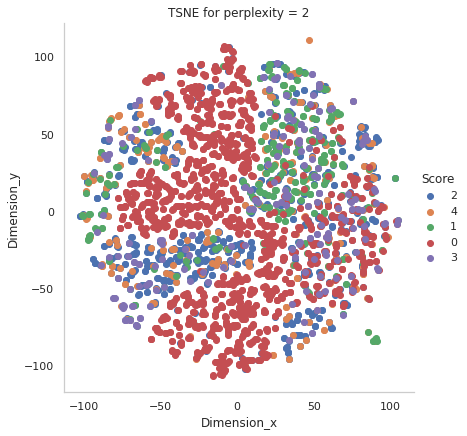

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


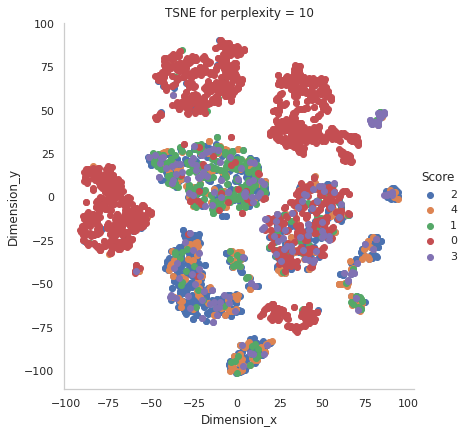

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


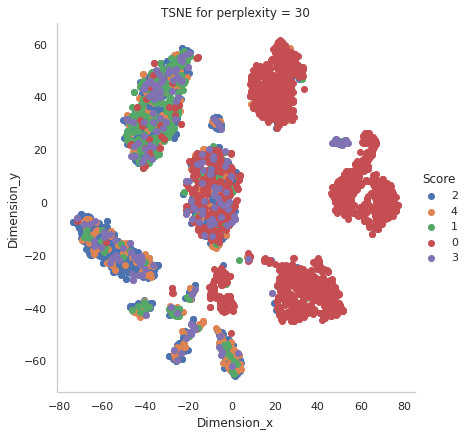

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


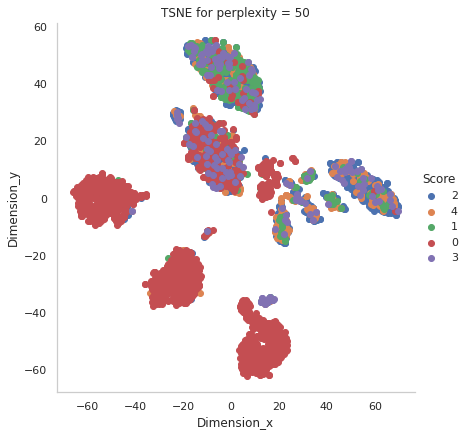

In [ ]:
per_vals = [2,10,30,50]

for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity = per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values
    
    sns.FacetGrid(df_tsne, hue='Score', size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()

Plot summary - As we can see, we are able to seperate Class '0' from other classes (1-4). Seperating between classes 1-4 looks challenging.

## Data Augmentation

In [ ]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(3662, 224, 224, 3)
(3662, 5)


In [122]:
from sklearn.model_selection import train_test_split

val_split = 0.25
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=val_split, stratify=Y_train)

X = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

In [ ]:
# define data augmentation configuration
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                                  rescale=1./255,
                                 rotation_range=360,
                                 brightness_range=[0.5, 1.5],
                                 zoom_range=[1, 1.2],
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='constant',
                                  validation_split=0.25)

# fit the data augmentation
train_datagen.fit(X)

In [ ]:
def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    print(img_arr.shape)
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 

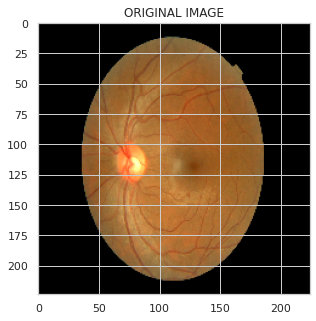

(1, 224, 224, 3)


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


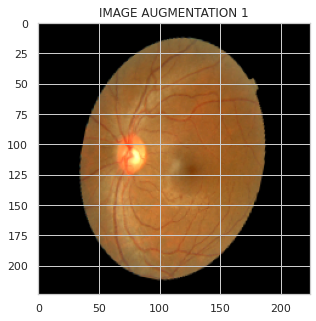

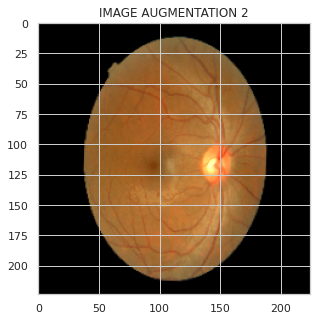

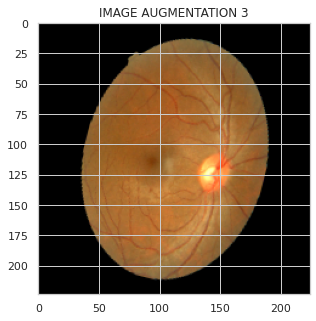

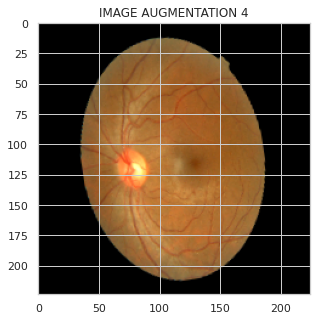

In [ ]:
generate_augmentations(4)

## BaseLine Model 

In [ ]:
from tensorflow import keras
from keras import models, layers
import tensorflow as tf


In [ ]:
print(x_train.shape)

(2746, 224, 224, 3)


In [ ]:
#Model 1- Most Basic Model
#Accuracy- 23% with augmented data

# with tf.device(device_name):
model1 = models.Sequential()
model1.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding="SAME", activation='relu', input_shape=(224, 224, 3)))
model1.add(layers.MaxPooling2D(pool_size= (3, 3), strides=2, padding="VALID"))
model1.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding="SAME", activation='relu'))
model1.add(layers.MaxPooling2D(pool_size= (3, 3), strides=2, padding="VALID"))
model1.add(layers.Flatten())
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(5, activation='softmax'))


In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 128)     18560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 387200)            0         
                                                                 
 dense (Dense)               (None, 16)                6

In [ ]:
from keras.optimizers import Adam
model1.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

In [ ]:
#Model 1 without using data augmentations
history = model1.fit( x_train, y_train,
         verbose=1,
         epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
86/86 [==============================] - 26s 70ms/step - loss: 0.0000e+00 - accuracy: 0.0062 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 5s 62ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
86/86 [==============================] - 5s 62ms/step - loss: 0.0000e+00 - accuracy: 0.0768 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
86/86 [==============================] - 5s 63ms/step - loss: 0.0000e+00 - accuracy: 0.1839 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
86/86 [==============================] - 5s 63ms/step - loss: 0.0000e+00 - accuracy: 0.1865 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
86/86 [==============================] - 5s 62ms/step - loss: 0.0000e+00 - accuracy: 0.2003 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
86/86 [==============================] - 6s 64ms/step - loss: 0.0000e+

In [ ]:
# Begin training
#Model 1 using data augmentations with learning rate = 0.01 (default)
model1.fit(train_datagen.flow(X, y, batch_size=32,
         subset='training'),
         validation_data=train_datagen.flow(X, y,
         batch_size=32, subset='validation'),
         batch_size = 32,
         epochs=5)

Epoch 1/5
86/86 [==============================] - 42s 490ms/step - loss: 0.0000e+00 - accuracy: 0.6130 - val_loss: 0.0000e+00 - val_accuracy: 0.5716
Epoch 2/5
86/86 [==============================] - 40s 463ms/step - loss: 0.0000e+00 - accuracy: 0.4623 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
86/86 [==============================] - 42s 484ms/step - loss: 0.0000e+00 - accuracy: 0.2406 - val_loss: 0.0000e+00 - val_accuracy: 0.3224
Epoch 4/5
86/86 [==============================] - 43s 498ms/step - loss: 0.0000e+00 - accuracy: 0.2621 - val_loss: 0.0000e+00 - val_accuracy: 0.6634
Epoch 5/5
86/86 [==============================] - 40s 468ms/step - loss: 0.0000e+00 - accuracy: 0.2748 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [ ]:
from keras.optimizers import Adam
model1.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

In [ ]:
# Begin training # learning_rate- 0.00005
# Begin training
#Model 1 using data augmentations with learning rate = 0.00005
model1.fit(train_datagen.flow(X, y, batch_size=32,
         subset='training'),
         validation_data=train_datagen.flow(X, y,
         batch_size=32, subset='validation'),
         batch_size = 32,
         epochs=5)

Epoch 1/5
86/86 [==============================] - 47s 439ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
86/86 [==============================] - 38s 441ms/step - loss: 0.0000e+00 - accuracy: 0.2024 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
86/86 [==============================] - 38s 440ms/step - loss: 0.0000e+00 - accuracy: 0.2515 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
86/86 [==============================] - 38s 438ms/step - loss: 0.0000e+00 - accuracy: 0.2712 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/5
86/86 [==============================] - 37s 437ms/step - loss: 0.0000e+00 - accuracy: 0.2548 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
# Begin training # learning_rate- 0.00005
# Begin training
#Model 1 using data augmentations with learning rate = 0.00005
model1.fit(train_datagen.flow(X, y, batch_size=32,
         subset='training'),
         validation_data=train_datagen.flow(X, y,
         batch_size=64, subset='validation'),
         batch_size = 64,
         epochs=50)

Epoch 1/50
86/86 [==============================] - 38s 446ms/step - loss: 0.0000e+00 - accuracy: 0.2730 - val_loss: 0.0000e+00 - val_accuracy: 0.6470
Epoch 2/50
86/86 [==============================] - 38s 437ms/step - loss: 0.0000e+00 - accuracy: 0.2748 - val_loss: 0.0000e+00 - val_accuracy: 0.8055
Epoch 3/50
86/86 [==============================] - 38s 438ms/step - loss: 0.0000e+00 - accuracy: 0.2676 - val_loss: 0.0000e+00 - val_accuracy: 0.6667
Epoch 4/50
86/86 [==============================] - 37s 436ms/step - loss: 0.0000e+00 - accuracy: 0.2523 - val_loss: 0.0000e+00 - val_accuracy: 0.0022
Epoch 5/50
86/86 [==============================] - 38s 438ms/step - loss: 0.0000e+00 - accuracy: 0.2734 - val_loss: 0.0000e+00 - val_accuracy: 0.7749
Epoch 6/50
86/86 [==============================] - 37s 436ms/step - loss: 0.0000e+00 - accuracy: 0.2541 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
86/86 [==============================] - 37s 437ms/step - loss: 0.0000e+00 - accura

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
result = model1.evaluate(train_datagen.flow(X_train, y_train,
         batch_size=32, subset='validation'))

In [ ]:
#Model 2
#Accuracy- 23% with augmented data
model2=models.Sequential()
model2.add(layers.Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(200,200,3)))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Dropout(0.2))
model2.add(layers.Flatten())
model2.add(layers.Dense(500,activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(5,activation="softmax"))#5 represent output layer neurons
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 200, 200, 16)      208       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      2080      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)      

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 200, 200, 16)      208       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      2080      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)      

In [ ]:
from keras.optimizers import Adam
model2.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

In [ ]:
# Begin training # learning_rate- 0.00005
model2.fit(train_datagen.flow(X, y, batch_size=32,
         subset='training'),
         validation_data=train_datagen.flow(X, y,
         batch_size=32, subset='validation'),
         batch_size = 32,
         epochs=5)

Epoch 1/5
86/86 [==============================] - 129s 1s/step - loss: 0.0000e+00 - accuracy: 0.1908 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
86/86 [==============================] - 127s 1s/step - loss: 0.0000e+00 - accuracy: 0.1904 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
86/86 [==============================] - 127s 1s/step - loss: 0.0000e+00 - accuracy: 0.1846 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/5
86/86 [==============================] - 128s 1s/step - loss: 0.0000e+00 - accuracy: 0.1740 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/5
86/86 [==============================] - 128s 1s/step - loss: 0.0000e+00 - accuracy: 0.1726 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


Our task is to identify the severity of blindness a person has. So it is very important to identify if a person has diabetic blindness or not. We may take the risk of categorizing a person as blind even if he is not but we should not classify a person having severe blindness to 0. 

Therefore we can take the risk of having false positives but not false negatives. Thus we try to decrease false negatives as much as possible and we know by the definition of recall, it is equal to true positives/(false negatives +true positives). If we decrease false negatives, recall increases. Recall measures the senstivity of the model.

Therefore we will use "recall" for measuring the performance of our model and try to increase it.

### Trying with different CNN Models 

In [ ]:
from tensorflow import keras
from keras import models, layers
import tensorflow as tf


In [ ]:
print(x_train.shape)

(2746, 224, 224, 3)


In [ ]:
#Model 1- Most Basic Model
#Accuracy- 23% with augmented data

# with tf.device(device_name):
model1 = models.Sequential()
model1.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding="SAME", activation='relu', input_shape=(224, 224, 3)))
model1.add(layers.MaxPooling2D(pool_size= (3, 3), strides=2, padding="VALID"))
model1.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding="SAME", activation='relu'))
model1.add(layers.MaxPooling2D(pool_size= (3, 3), strides=2, padding="VALID"))
model1.add(layers.Flatten())
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(5, activation='softmax'))


In [ ]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 111, 111, 128)     18560     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 55, 55, 128)      0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 387200)            0         
                                                                 
 dense_16 (Dense)            (None, 16)               

In [ ]:
from keras.optimizers import Adam
model1.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

In [ ]:
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [ ]:
#Model 1 without using data augmentations
history = model1.fit( x_train, y_train,
         verbose=1,
         epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
86/86 [==============================] - 2s 19ms/step - loss: 42.2137 - accuracy: 0.4552 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
86/86 [==============================] - 1s 14ms/step - loss: 1.5517 - accuracy: 0.4876 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
86/86 [==============================] - 1s 14ms/step - loss: 1.5121 - accuracy: 0.4876 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
86/86 [==============================] - 1s 14ms/step - loss: 1.4766 - accuracy: 0.4876 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
86/86 [==============================] - 1s 14ms/step - loss: 1.4457 - accuracy: 0.4876 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
86/86 [==============================] - 1s 14ms/step - loss: 1.4193 - accuracy: 0.4876 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
86/86 [==============================] - 1s 14ms/step - loss: 1.3968 - accuracy: 0.4876 - val_loss: 0.0000e+00 - val_a

In [ ]:
from keras.optimizers import Adam
model1.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

In [ ]:
# Begin training # learning_rate- 0.00005
# Begin training
#Model 1 using data augmentations with learning rate = 0.00005
model1.fit(train_datagen.flow(X, y, batch_size=32,
         subset='training'),
         validation_data=train_datagen.flow(X, y,
         batch_size=32, subset='validation'),
         batch_size = 32,
         epochs=5)

In [ ]:
result = model1.evaluate(train_datagen.flow(X,y,
         batch_size=32, subset='validation'))

In [ ]:
#Model 2
#Accuracy- 23% with augmented data
model2=models.Sequential()
model2.add(layers.Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(200,200,3)))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Dropout(0.2))
model2.add(layers.Flatten())
model2.add(layers.Dense(500,activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(5,activation="softmax"))#5 represent output layer neurons
model2.summary()

In [ ]:
model2.summary()

In [ ]:
from keras.optimizers import Adam
model2.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

In [ ]:
# Begin training # learning_rate- 0.00005
model2.fit(train_datagen.flow(X, y, batch_size=32,
         subset='training'),
         validation_data=train_datagen.flow(X, y,
         batch_size=32, subset='validation'),
         batch_size = 32,
         epochs=5)

## Baseline with VGG reference with 3 blocks 



In [ ]:
from tensorflow import keras
from keras import layers, models

#Model 3 VGG 
#Accuracy- 23% with augmented data
model3=models.Sequential()
model3.add(layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu",input_shape=(200,200,3)))
model3.add(layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model3.add(layers.MaxPooling2D(pool_size=2))
model3.add(layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model3.add(layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model3.add(layers.MaxPooling2D(pool_size=2))
model3.add(layers.Conv2D(filters=128,kernel_size=3,padding="same",activation="relu"))
model3.add(layers.Conv2D(filters=128,kernel_size=3,padding="same",activation="relu"))
model3.add(layers.MaxPooling2D(pool_size=2))
model3.add(layers.Dropout(0.2))
model3.add(layers.Flatten())
model3.add(layers.Dense(128,activation="relu"))
model3.add(layers.Dense(5,activation="softmax"))#5 represent output layer neurons
model3.summary()

In [ ]:
model3.summary()

In [ ]:

model3.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

In [ ]:
history=model3.fit(train_datagen.flow(X, y, batch_size=32,
         subset='training'),
         validation_data=train_datagen.flow(X, y,
         batch_size=32, subset='validation'),
         batch_size = 32,
         epochs=5)

In [ ]:
from tensorflow import keras
from keras import layers, models
with tf.device(device_name):
  #Model 3 VGG 
  #Accuracy- 23% with augmented data
  model3=models.Sequential()
  model3.add(layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu",input_shape=(200,200,3)))
  model3.add(layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
  model3.add(layers.MaxPooling2D(pool_size=2))
  model3.add(layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
  model3.add(layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
  model3.add(layers.MaxPooling2D(pool_size=2))
  model3.add(layers.Conv2D(filters=128,kernel_size=3,padding="same",activation="relu"))
  model3.add(layers.Conv2D(filters=128,kernel_size=3,padding="same",activation="relu"))
  model3.add(layers.MaxPooling2D(pool_size=2))
  model3.add(layers.Dropout(0.2))
  model3.add(layers.Flatten())
  model3.add(layers.Dense(128,activation="relu"))
  model3.add(layers.Dense(5,activation="softmax"))#5 represent output layer neurons
  model3.summary()
  model3.compile(
          loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy']
      )



In [ ]:
history=model3.fit( x_train, y_train, 
         batch_size = 32,
         epochs=5, validation_data=(x_val, y_val))

## Baseline with VGG reference 2 blocks 


In [ ]:
from tensorflow import keras
from keras import layers, models

#Model 3 VGG 
#Accuracy- 23% with augmented data
model4=models.Sequential()
model4.add(layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu",input_shape=(224,224,3)))
model4.add(layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model4.add(layers.MaxPooling2D(pool_size=2))
model4.add(layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model4.add(layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model4.add(layers.MaxPooling2D(pool_size=2))
model4.add(layers.Dropout(0.2))
model4.add(layers.Flatten())
model4.add(layers.Dense(128,activation="relu"))
model4.add(layers.Dense(5,activation="softmax"))#5 represent output layer neurons
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

In [ ]:
model4.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

In [ ]:
history=model4.fit(train_datagen.flow(X, y, batch_size=32,
         subset='training'),
         validation_data=train_datagen.flow(X, y,
         batch_size=32, subset='validation'),
         batch_size = 32,
         epochs=5)

Epoch 1/5
86/86 [==============================] - 51s 553ms/step - loss: 0.0000e+00 - accuracy: 0.2246 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
86/86 [==============================] - 43s 500ms/step - loss: 0.0000e+00 - accuracy: 0.1918 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
86/86 [==============================] - 43s 495ms/step - loss: 0.0000e+00 - accuracy: 0.1980 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/5
86/86 [==============================] - 43s 501ms/step - loss: 0.0000e+00 - accuracy: 0.1980 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/5
86/86 [==============================] - 42s 486ms/step - loss: 0.0000e+00 - accuracy: 0.2097 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [ ]:
history=model4.fit(x_train, y_train,
         batch_size = 32,
         epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
86/86 [==============================] - 13s 148ms/step - loss: 0.0000e+00 - accuracy: 0.1981 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
86/86 [==============================] - 10s 121ms/step - loss: 0.0000e+00 - accuracy: 0.1959 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
86/86 [==============================] - 10s 122ms/step - loss: 0.0000e+00 - accuracy: 0.1959 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
86/86 [==============================] - 11s 123ms/step - loss: 0.0000e+00 - accuracy: 0.2054 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/5
86/86 [==============================] - 11s 124ms/step - loss: 0.0000e+00 - accuracy: 0.1865 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


##  Transfer learning with ResNet 50 Model

In [ ]:
# we are going to apply tranfer learning using densenet-121
from keras.applications import ResNet50
resnet = ResNet50(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
# building model using Densenet-121
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
def build_model():
    model = Sequential()
    model.add(resnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Begin training
model.fit(np.array(x_train), np.array(y_train),
                    batch_size = 32,
                    epochs=5, validation_data = (x_test, y_test))

Epoch 1/5
86/86 [==============================] - 1317s 15s/step - loss: 0.6997 - accuracy: 0.7524 - val_loss: 1.0196 - val_accuracy: 0.6550
Epoch 2/5
86/86 [==============================] - 1311s 15s/step - loss: 0.5706 - accuracy: 0.7968 - val_loss: 1.7823 - val_accuracy: 0.5175
Epoch 3/5
86/86 [==============================] - 1311s 15s/step - loss: 0.5720 - accuracy: 0.7866 - val_loss: 3.0558 - val_accuracy: 0.5262
Epoch 4/5
86/86 [==============================] - 1308s 15s/step - loss: 0.4717 - accuracy: 0.8314 - val_loss: 1.5916 - val_accuracy: 0.5109
Epoch 5/5
86/86 [==============================] - 1309s 15s/step - loss: 0.4125 - accuracy: 0.8591 - val_loss: 1.7055 - val_accuracy: 0.6026


In [ ]:
_, accuracy= model.evaluate(x_train, y_train)
print('Training Accuracy: %.2f' % (accuracy*100))

86/86 [==============================] - 295s 3s/step - loss: 1.3914 - accuracy: 0.6282
Training Accuracy: 62.82


In [ ]:
_, accuracy= model.evaluate(x_val, y_val)
print('Validation Accuracy: %.2f' % (accuracy*100))

29/29 [==============================] - 98s 3s/step - loss: 1.7055 - accuracy: 0.6026
Validation Accuracy: 60.26


## Transfer Learning with Inception Model

In [ ]:
from keras.applications import InceptionV3
densenet = InceptionV3(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
x_train= np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test = np.array(y_test)

In [ ]:
# Begin training
model.fit(x_train, y_train,
                    batch_size = 32,
                    epochs=5, validation_data = (x_test, y_test))

Epoch 1/5
86/86 [==============================] - 1495s 17s/step - loss: 1.0834 - accuracy: 0.6209 - val_loss: 2.1411 - val_accuracy: 0.2642
Epoch 2/5
86/86 [==============================] - 1465s 17s/step - loss: 0.8907 - accuracy: 0.6748 - val_loss: 2.9036 - val_accuracy: 0.2642
Epoch 3/5
86/86 [==============================] - 1451s 17s/step - loss: 0.8269 - accuracy: 0.6985 - val_loss: 2.6950 - val_accuracy: 0.1190
Epoch 4/5
86/86 [==============================] - 1460s 17s/step - loss: 0.7771 - accuracy: 0.7189 - val_loss: 2.1752 - val_accuracy: 0.2969
Epoch 5/5
86/86 [==============================] - 1468s 17s/step - loss: 0.7378 - accuracy: 0.7312 - val_loss: 0.9166 - val_accuracy: 0.6463


In [ ]:
_, accuracy= model.evaluate(x_train, y_train)
print('Training Accuracy: %.2f' % (accuracy*100))

86/86 [==============================] - 285s 3s/step - loss: 0.8218 - accuracy: 0.6959
Training Accuracy: 69.59


In [ ]:
_, accuracy= model.evaluate(x_test, y_test)
print('Validation Accuracy: %.2f' % (accuracy*100))

29/29 [==============================] - 95s 3s/step - loss: 0.9166 - accuracy: 0.6463
Validation Accuracy: 64.63


## Transfer Learning with Dense Net

In [ ]:
# we are going to apply tranfer learning using densenet-121
from keras.applications import DenseNet121
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
# building model using Densenet-121
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print(X.shape)

(3662, 224, 224, 3)


In [ ]:
# Begin training
model.fit(np.array(x_train), np.array(y_train),
                    batch_size = 32,
                    epochs=50, validation_data = (x_val, y_val))

Epoch 1/50
86/86 [==============================] - 64s 450ms/step - loss: 1.0512 - accuracy: 0.6071 - val_loss: 1.2396 - val_accuracy: 0.5197
Epoch 2/50
86/86 [==============================] - 33s 382ms/step - loss: 0.8176 - accuracy: 0.7036 - val_loss: 1.8094 - val_accuracy: 0.2751
Epoch 3/50
86/86 [==============================] - 34s 392ms/step - loss: 0.7287 - accuracy: 0.7298 - val_loss: 0.9773 - val_accuracy: 0.6026
Epoch 4/50
86/86 [==============================] - 34s 392ms/step - loss: 0.6718 - accuracy: 0.7553 - val_loss: 0.9223 - val_accuracy: 0.6092
Epoch 5/50
86/86 [==============================] - 34s 390ms/step - loss: 0.6272 - accuracy: 0.7717 - val_loss: 1.0035 - val_accuracy: 0.6408
Epoch 6/50
86/86 [==============================] - 34s 393ms/step - loss: 0.5490 - accuracy: 0.7997 - val_loss: 0.9738 - val_accuracy: 0.6419
Epoch 7/50
86/86 [==============================] - 34s 392ms/step - loss: 0.4868 - accuracy: 0.8237 - val_loss: 0.7444 - val_accuracy: 0.7063

In [ ]:
_, accuracy= model.evaluate(x_train, y_train)
print('Training Accuracy: %.2f' % (accuracy*100))

86/86 [==============================] - 8s 94ms/step - loss: 0.4190 - accuracy: 0.8937
Training Accuracy: 89.37


In [ ]:
_, accuracy= model.evaluate(x_val, y_val)
print('Validation Accuracy: %.2f' % (accuracy*100))

29/29 [==============================] - 3s 93ms/step - loss: 1.8820 - accuracy: 0.7631
Validation Accuracy: 76.31


In [ ]:
y_pred=model.predict(np.array(x_val))
print(y_pred)

29/29 [==============================] - 3s 90ms/step
[[2.41318162e-07 2.71858109e-08 9.99999642e-01 1.11496306e-08
  7.51847935e-08]
 [9.96133327e-01 3.60297947e-03 2.45305622e-04 7.06626633e-06
  1.13871001e-05]
 [2.29290407e-07 1.25735755e-06 9.99998212e-01 1.53395618e-07
  1.88852653e-07]
 ...
 [9.99374807e-01 5.12286206e-04 1.04200852e-04 3.88773697e-06
  4.88460864e-06]
 [2.48129766e-07 1.80233201e-07 9.99999404e-01 7.12696462e-08
  9.96969174e-09]
 [3.01247120e-01 5.94798863e-01 1.02960870e-01 4.72157844e-04
  5.21027134e-04]]


In [ ]:
y_pred2=np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_scorey_pred2=np.argmax(y_pred, axis=1)
print(confusion_matrix(y_val, y_pred2))

[[442   2   7   0   0]
 [  6  33  54   0   0]
 [ 16  10 222   2   0]
 [  3   0  44   0   1]
 [  1   4  67   0   2]]


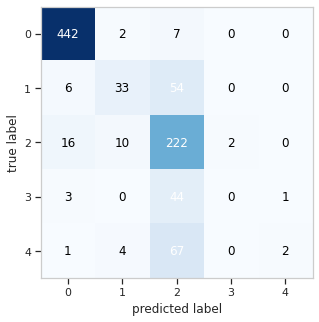

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_val, y_pred2), figsize=(5, 5))

In [ ]:
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       451
           1       0.50      0.15      0.23        93
           2       0.61      0.70      0.65       250
           3       0.12      0.08      0.10        48
           4       0.33      0.42      0.37        74

    accuracy                           0.72       916
   macro avg       0.50      0.46      0.46       916
weighted avg       0.70      0.72      0.70       916



In [ ]:
print(accuracy_score(y_val, y_pred2))

0.7631004366812227


In [ ]:
model.save('densenet121.h5')

## Applying attention mechanism on densenet model

In [ ]:
from keras.layers import Input, BatchNormalization, Conv2D, Dropout

In [ ]:
in_lay = Input(shape=(224, 224,3))
base_model = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
                  
model.load_weights("densenet121.h5")
pt_features = base_model(in_lay)
bn_features = BatchNormalization()(pt_features)

In [ ]:
from keras.models import Model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)

In [ ]:
# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, 1024))
up_c2 = Conv2D(1024, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)
print("bn_features: ", bn_features)
mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(5, activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

bn_features:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1024), dtype=tf.float32, name=None), name='batch_normalization_19/FusedBatchNormV3:0', description="created by layer 'batch_normalization_19'")


In [ ]:
retina_model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print(y_train[0])

[1 0 0 0 0]


In [ ]:
print(y_val[0])

[1 0 0 0 0]


In [ ]:
# Begin training
retina_model.fit(np.array(x_train), np.array(y_train),
                    batch_size = 32,
                    epochs=50, validation_data = (x_val, y_val))

Epoch 1/50
86/86 [==============================] - 46s 395ms/step - loss: 0.9654 - accuracy: 0.6497 - val_loss: 1.7060 - val_accuracy: 0.2729
Epoch 2/50
86/86 [==============================] - 32s 378ms/step - loss: 0.7816 - accuracy: 0.7160 - val_loss: 2.3379 - val_accuracy: 0.2729
Epoch 3/50
86/86 [==============================] - 33s 381ms/step - loss: 0.7107 - accuracy: 0.7407 - val_loss: 1.9387 - val_accuracy: 0.2806
Epoch 4/50
86/86 [==============================] - 33s 386ms/step - loss: 0.6402 - accuracy: 0.7626 - val_loss: 0.7387 - val_accuracy: 0.7413
Epoch 5/50
86/86 [==============================] - 33s 388ms/step - loss: 0.6029 - accuracy: 0.7779 - val_loss: 0.7997 - val_accuracy: 0.6507
Epoch 6/50
86/86 [==============================] - 34s 391ms/step - loss: 0.5351 - accuracy: 0.8114 - val_loss: 1.1746 - val_accuracy: 0.5873
Epoch 7/50
86/86 [==============================] - 34s 392ms/step - loss: 0.4778 - accuracy: 0.8281 - val_loss: 1.0432 - val_accuracy: 0.6004

In [ ]:
_, accuracy= retina_model.evaluate(x_val, y_val)
print('Validation Accuracy: %.2f' % (accuracy*100))

29/29 [==============================] - 3s 91ms/step - loss: 1.0962 - accuracy: 0.7598
Validation Accuracy: 75.98


In [ ]:
y_pred=np.argmax(model.predict(np.array(x_val)))

29/29 [==============================] - 4s 87ms/step




```
# This is formatted as code
```

## EfficientNet Model

DenseNet Model which gave training Accuracy is 76.18 and validation accuracy is 72.49

In [136]:
!pip install -U git+https://github.com/qubvel/efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-fioam_85
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-fioam_85
     |████████████████████████████████| 50 kB 5.6 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=4466503632169c11f47cd2534a0a1477a62598758569324b197bc01b32c6b5ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-k7zuuual/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [137]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
!pip install -U --pre efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
import efficientnet.tfkeras
from keras.models import load_model

effnet = efficientnet.tfkeras.EfficientNetB5(weights="imagenet",
                        include_top=False,
                        input_shape=(224, 224, 3))

115515256/115515256 [==============================] - 14s 0us/step


In [ ]:
for i, layer in enumerate(effnet.layers):
    if "batch_normalization" in layer.name:
        effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

In [ ]:
!pip install keras-rectified-adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8271 sha256=bfd88b0c832e3a068665196a208f82eba89be4c68768fd835ce81dab30a48df4
  Stored in directory: /root/.cache/pip/wheels/5d/1f/40/3fe78c6f4dd6f0522c558077283361e7d50fd7720d2f8fcd7e
Successfully built keras-rectified-adam


In [143]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

def build_model():
    model = Sequential()
    model.add(effnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [144]:
model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 7, 7, 2048)       28513520  
 )                                                               
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_27 (Dropout)        (None, 2048)              0         
                                                                 
 dense_21 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [145]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)


In [148]:
# Begin training
model.fit(x_train, y_train,
                    batch_size = 16,
                    epochs=10, validation_data = (x_val, y_val))

Epoch 1/10
172/172 [==============================] - 99s 576ms/step - loss: 0.6749 - accuracy: 0.7626 - val_loss: 0.6029 - val_accuracy: 0.7675
Epoch 2/10
172/172 [==============================] - 95s 551ms/step - loss: 0.4998 - accuracy: 0.8223 - val_loss: 0.5868 - val_accuracy: 0.7871
Epoch 3/10
172/172 [==============================] - 96s 560ms/step - loss: 0.3795 - accuracy: 0.8627 - val_loss: 0.5245 - val_accuracy: 0.8100
Epoch 4/10
172/172 [==============================] - 96s 559ms/step - loss: 0.2753 - accuracy: 0.9057 - val_loss: 0.5264 - val_accuracy: 0.8144
Epoch 5/10
172/172 [==============================] - 96s 560ms/step - loss: 0.1954 - accuracy: 0.9355 - val_loss: 0.5587 - val_accuracy: 0.8013
Epoch 6/10
172/172 [==============================] - 96s 560ms/step - loss: 0.1458 - accuracy: 0.9530 - val_loss: 0.5967 - val_accuracy: 0.8122
Epoch 7/10
172/172 [==============================] - 96s 561ms/step - loss: 0.1172 - accuracy: 0.9650 - val_loss: 0.6165 - val_ac

Thus we got a best accuracy of 82.97 in epochs for efficent net model

## Attention Model on Efficient Net

In [149]:
# from keras.layers.normalization import BatchNormalization
from keras.layers import Input, BatchNormalization, multiply, Lambda

in_lay = Input(shape=(224,224,3))
base_model = efficientnet.tfkeras.EfficientNetB5(weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
                   )

pt_features = base_model(in_lay)
bn_features = BatchNormalization()(pt_features)

In [ ]:
pt_depth=2048

In [ ]:
from keras.models import Model

In [ ]:
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, 2048))
up_c2 = Conv2D(pt_depth , kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(5, activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

In [ ]:
retina_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b5 (Functional)   (None, 7, 7, 2048)   28513520    ['input_25[0][0]']               
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 7, 7, 2048)  8192        ['efficientnet-b5[0][0]']        
 rmalization)                                                                                     
                                                                                            

In [ ]:
retina_model.compile(loss='mse',
                  optimizer=Adam(lr=0.00005), 
                  metrics=['mse', 'acc'])

In [ ]:
retina_model.fit(x_train, y_train,
                    batch_size = 16,
                    epochs=5, validation_data = (x_val, y_val))

Epoch 1/5
172/172 [==============================] - 112s 651ms/step - loss: 0.0068 - mse: 0.0068 - acc: 0.9792 - val_loss: 0.0646 - val_mse: 0.0646 - val_acc: 0.8079
Epoch 2/5
172/172 [==============================] - 116s 673ms/step - loss: 0.0065 - mse: 0.0065 - acc: 0.9811 - val_loss: 0.0637 - val_mse: 0.0637 - val_acc: 0.8199
Epoch 3/5
172/172 [==============================] - 111s 646ms/step - loss: 0.0067 - mse: 0.0067 - acc: 0.9785 - val_loss: 0.0622 - val_mse: 0.0622 - val_acc: 0.8133
Epoch 4/5
172/172 [==============================] - 111s 648ms/step - loss: 0.0066 - mse: 0.0066 - acc: 0.9792 - val_loss: 0.0575 - val_mse: 0.0575 - val_acc: 0.8253
Epoch 5/5
172/172 [==============================] - 111s 647ms/step - loss: 0.0063 - mse: 0.0063 - acc: 0.9811 - val_loss: 0.0614 - val_mse: 0.0614 - val_acc: 0.8057
